# **Setup & Imports**

In [ ]:
# Mount your Google Drive (uncomment in Colab)
from google.colab import drive
drive.mount('/content/drive')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
import seaborn as sns

from prophet import Prophet
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error, mean_absolute_error
import shap
from sklearn.ensemble import RandomForestClassifier

Mounted at /content/drive


In [ ]:
# Load CSVs from your Drive (update the paths as needed)
profiles = pd.read_csv('/content/drive/MyDrive/PLAN OF ACTION/PROJECTS/datasets_churn/All_Profiles.csv', parse_dates=['Profile Creation Time'],dayfirst=True)
devices  = pd.read_csv('/content/drive/MyDrive/PLAN OF ACTION/PROJECTS/datasets_churn/All_Devices.csv', parse_dates =['Acct First Playback Date','Acct Last Playback Date','Acct First Playback Date For User Generated Plays','Acct Last Playback Date For User Generated Plays','Profile First Playback Date','Profile Last Playback Date','Profile First Playback Date For User Generated Plays','Profile Last Playback Date For User Generated Plays','Deactivation Time'],dayfirst=True)
clicks   = pd.read_csv('/content/drive/MyDrive/PLAN OF ACTION/PROJECTS/datasets_churn/All_Clickstream.csv', parse_dates=['Click Utc Ts'],dayfirst=True)
search   = pd.read_csv('/content/drive/MyDrive/PLAN OF ACTION/PROJECTS/datasets_churn/All_SearchHistory.csv', parse_dates=['Utc Timestamp'],dayfirst=True)
view     = pd.read_csv('/content/drive/MyDrive/PLAN OF ACTION/PROJECTS/datasets_churn/All_ViewingActivity.csv', parse_dates=['Start Time'],dayfirst=True)

/tmp/ipython-input-120057986.py:6: UserWarning: Parsing dates in %Y-%m-%d %H:%M:%S format when dayfirst=True was specified. Pass `dayfirst=False` or specify a format to silence this warning.
  view     = pd.read_csv('/content/drive/MyDrive/PLAN OF ACTION/PROJECTS/datasets_churn/All_ViewingActivity.csv', parse_dates=['Start Time'],dayfirst=True)


# ****Data Cleaning & Preprocessing****

In [ ]:
  profiles_cleaned_again = profiles.dropna(axis=1, how='all')
  devices_cleaned_again = devices.dropna(axis=1, how='all')
  clicks_cleaned_again = clicks.dropna(axis=1, how='all')
  search_cleaned_again = search.dropna(axis=1, how='all')
  view_cleaned_again = view.dropna(axis=1, how='all')
  display(profiles_cleaned_again.head(10))
  display(devices_cleaned_again.head(10))
  display(clicks_cleaned_again.head(10))
  display(search_cleaned_again.head(10))
  display(view_cleaned_again.head(10))

,Profile Name,Profile Creation Time,Maturity Level,Primary Lang,Has Auto Playback,Max Stream Quality,Profile Lock Enabled,Profile Transferred,Opt-Out,Privacy And Data Settings
0,User 0,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN
1,User 1,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN
2,User 2,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN
3,User 3,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN
4,User 4,2021-10-29 05:19:00,ADULTS,en-IN,NaN,Unknown,False,False,{},NaN
5,User 5,2023-01-07 14:07:00,ADULTS,en-IN,1.0,Unknown,False,False,NaN,{}
6,User 6,2022-06-13 18:09:00,ADULTS,en-IN,1.0,Unknown,False,False,NaN,{}
7,User 7,2022-06-05 16:43:00,ADULTS,en-IN,1.0,Unknown,False,False,NaN,{}
8,User 8,2022-06-01 13:24:00,ADULTS,en-IN,NaN,Unknown,False,False,NaN,{}


,Profile Name,Esn,Device Type,Acct First Playback Date,Acct Last Playback Date,Acct First Playback Date For User Generated Plays,Acct Last Playback Date For User Generated Plays,Profile First Playback Date,Profile Last Playback Date,Profile First Playback Date For User Generated Plays,Profile Last Playback Date For User Generated Plays,Deactivation Time
0,User 3,Esn 1,Device Type 4,2022-04-01T09:32:16.028Z,2022-11-07T12:57:43.624Z,2022-04-01T09:32:16.028Z,2022-11-07T12:57:43.624Z,2022-04-01T09:32:16.028Z,2022-11-07T12:57:43.624Z,2022-04-01T09:32:16.028Z,2022-11-07T12:57:43.624Z,NaN
1,User 1,Esn 6,Device Type 0,2021-12-24T14:40:29.147Z,2022-10-06T17:29:04.497Z,2021-12-24T14:40:29.147Z,2022-10-06T17:29:04.497Z,NaN,NaN,NaN,NaN,NaN
2,User 2,Esn 6,Device Type 0,2021-12-24T14:40:29.147Z,2022-10-06T17:29:04.497Z,2021-12-24T14:40:29.147Z,2022-10-06T17:29:04.497Z,NaN,NaN,NaN,NaN,NaN
3,User 3,Esn 6,Device Type 0,2021-12-24T14:40:29.147Z,2022-10-06T17:29:04.497Z,2021-12-24T14:40:29.147Z,2022-10-06T17:29:04.497Z,NaN,NaN,NaN,NaN,NaN
4,User 0,Esn 6,Device Type 0,2021-12-24T14:40:29.147Z,2022-10-06T17:29:04.497Z,2021-12-24T14:40:29.147Z,2022-10-06T17:29:04.497Z,2022-08-03T16:57:01.297Z,2022-10-06T17:29:04.497Z,2022-08-03T16:57:01.297Z,2022-10-06T17:29:04.497Z,NaN
5,User 4,Esn 0,Device Type 5,2021-10-31T07:55:44.140Z,2022-09-30T14:54:39.201Z,2021-10-31T07:57:20.172Z,2022-09-30T14:53:01.030Z,2021-10-31T07:55:44.140Z,2022-09-30T14:54:39.201Z,2021-10-31T07:57:20.172Z,2022-09-30T14:53:01.030Z,NaN
6,User 2,Esn 1,Device Type 4,2022-04-01T09:32:16.028Z,2022-11-07T12:57:43.624Z,2022-04-01T09:32:16.028Z,2022-11-07T12:57:43.624Z,NaN,NaN,NaN,NaN,NaN
7,User 0,Esn 1,Device Type 4,2022-04-01T09:32:16.028Z,2022-11-07T12:57:43.624Z,2022-04-01T09:32:16.028Z,2022-11-07T12:57:43.624Z,NaN,NaN,NaN,NaN,NaN
8,User 4,Esn 31,Device Type 1,2021-12-20T07:25:51.497Z,2022-09-12T04:59:59.916Z,2021-12-20T07:25:51.497Z,2022-09-12T04:59:59.916Z,2021-12-20T07:28:30.100Z,2022-09-12T04:59:59.916Z,2021-12-20T07:28:30.100Z,2022-09-12T04:59:59.916Z,NaN
9,User 4,Esn 1,Device Type 4,2022-04-01T09:32:16.028Z,2022-11-07T12:57:43.624Z,2022-04-01T09:32:16.028Z,2022-11-07T12:57:43.624Z,2022-04-23T10:31:24.249Z,2022-09-04T16:32:31.113Z,2022-04-23T10:31:24.249Z,2022-09-04T16:32:31.113Z,NaN


,Profile Name,Source,Navigation Level,Referrer Url,Webpage Url,Click Utc Ts
0,User 4,Source 0,signupPrompt,NaN,NaN,2022-10-08 14:04:47
1,User 4,Source 0,browseTitles,NaN,NaN,2022-10-08 14:04:46
2,User 4,Source 1,movieDetails,NaN,NaN,2022-09-30 14:53:50
3,User 4,Source 1,browseTitles,NaN,NaN,2022-09-30 14:53:50
4,User 4,Source 1,movieDetails,NaN,NaN,2022-09-30 14:53:49
5,User 4,Source 1,episodesSelector,NaN,NaN,2022-09-30 14:53:49
6,User 4,Source 1,episodesSelector,NaN,NaN,2022-09-30 14:53:24
7,User 4,Source 1,movieDetails,NaN,NaN,2022-09-30 14:53:24
8,User 4,Source 1,playback,NaN,NaN,2022-09-30 14:53:20
9,User 4,Source 1,movieDetails,NaN,NaN,2022-09-30 14:53:20


,Profile Name,Country Iso Code,Device,Is Kids,Query Typed,Displayed Name,Action,Section,Utc Timestamp
0,User 4,AE,Device 0,0,NaN,"Manifest: Season 1: ""Pilot""",play,prequery_results,2022-08-01 13:59:19
1,User 4,AE,Device 0,0,NaN,NaN,select,prequery_results,2022-08-01 13:59:18
2,User 4,AE,Device 0,0,NaN,"Manifest: Season 1: ""Pilot""",play,prequery_results,2022-08-01 13:59:07
3,User 4,AE,Device 0,0,NaN,NaN,select,prequery_results,2022-08-01 13:59:03
4,User 4,AE,Device 0,0,the gray,The Gray Man,add,title_results,2022-07-17 13:59:23
5,User 4,AE,Device 0,0,the gray,The Gray Man,select,title_results,2022-07-17 13:59:17
6,User 4,AE,Device 0,0,NaN,"Stranger Things 4: ""Chapter Nine: The Piggyback""",play,prequery_results,2022-07-01 17:39:31
7,User 4,AE,Device 0,0,NaN,"Stranger Things 4: ""Chapter Eight: Papa""",play,prequery_results,2022-07-01 17:16:37
8,User 4,AE,Device 0,0,NaN,"Stranger Things 4: ""Chapter Eight: Papa""",play,prequery_results,2022-07-01 17:15:22
9,User 4,AE,Device 0,0,NaN,"Stranger Things 4: ""Chapter Eight: Papa""",play,prequery_results,2022-07-01 17:04:54


,Profile Name,Start Time,Duration,Attributes,Title,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country
0,User 1,2022-04-28 16:08:56,00:00:06,NaN,Chernobyl 1986,NaN,Device Type 1,01:02:16,01:02:16,IN (India)
1,User 1,2022-04-28 15:54:30,00:09:39,NaN,13 Hours: The Secret Soldiers of Benghazi,NaN,Device Type 1,02:13:19,02:13:19,IN (India)
2,User 1,2022-04-28 15:53:20,00:00:06,NaN,Saving Private Ryan,NaN,Device Type 1,01:16:17,01:16:17,IN (India)
3,User 1,2022-04-28 15:52:18,00:00:15,NaN,Mosul,NaN,Device Type 1,01:06:44,01:06:44,IN (India)
4,User 1,2022-04-28 15:49:11,00:01:45,NaN,12 Strong,NaN,Device Type 1,00:52:28,00:52:28,IN (India)
5,User 1,2022-04-26 02:32:00,00:00:03,NaN,Fifty Shades of Grey,NaN,Device Type 1,01:45:06,01:45:06,IN (India)
6,User 1,2022-04-26 02:26:33,00:04:33,NaN,Jaoon Kahan Bata Ae Dil,NaN,Device Type 1,01:28:15,01:28:15,IN (India)
7,User 1,2022-04-26 02:13:30,00:12:13,NaN,Jaoon Kahan Bata Ae Dil,NaN,Device Type 1,01:21:49,Not latest view,IN (India)
8,User 1,2022-04-26 02:13:28,00:00:01,NaN,Jaoon Kahan Bata Ae Dil,NaN,Device Type 1,00:01:05,Not latest view,IN (India)
9,User 1,2022-04-26 02:13:00,00:00:24,NaN,Jaoon Kahan Bata Ae Dil,NaN,Device Type 1,00:01:12,Not latest view,IN (India)


In [ ]:
# Numeric columns (example: Duration if parsed, session length, etc.)
for col in ['Duration', 'Gap_Hours']:
    if col in view.columns:
        print(f"\n{col} summary:")
        print(view[col].describe())



# Unique values in object columns (categoricals)
for col in view.select_dtypes('object').columns:
    print(f"\n{col} unique values:")
    print(view[col].value_counts(dropna=False).head())



Duration summary:
count         9992
unique        2741
top       00:00:04
freq           320
Name: Duration, dtype: object

Profile Name unique values:
Profile Name
User 4    5239
User 8    1932
User 5     892
User 7     747
User 6     496
Name: count, dtype: int64

Duration unique values:
Duration
00:00:04    320
00:00:05    246
00:00:06    205
00:00:07    162
00:00:01    122
Name: count, dtype: int64

Attributes unique values:
Attributes
NaN                                                                   8593
Autoplayed: user action: None;                                         868
Autoplayed: user action: User_Interaction;                             482
Autoplayed: user action: Unspecified;                                   47
Has branched playback; Autoplayed: user action: User_Interaction;        2
Name: count, dtype: int64

Title unique values:
Title
Minnal Murali    40
Red Notice       24
Gatta Kusthi     22
Don't Look Up    22
Kumari           22
Name: count, dtype: int64

In [ ]:
print(f">> shape of data: {profiles_cleaned_again.shape}")
print(f">> type of data:")
print(profiles_cleaned_again.info())

print(f">> shape of data: {devices_cleaned_again.shape}")
print(f">> type of data:")
print(devices_cleaned_again.info())

print(f">> shape of data: {clicks_cleaned_again.shape}")
print(f">> type of data:")
print(clicks_cleaned_again.info())

print(f">> shape of data: {search_cleaned_again.shape}")
print(f">> type of data:")
print(search_cleaned_again.info())

print(f">> shape of data: {view_cleaned_again.shape}")
print(f">> type of data:")
print(view_cleaned_again.info())



>> shape of data: (9, 10)
>> type of data:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 9 entries, 0 to 8
Data columns (total 10 columns):
 #   Column                     Non-Null Count  Dtype         
---  ------                     --------------  -----         
 0   Profile Name               9 non-null      object        
 1   Profile Creation Time      9 non-null      datetime64[ns]
 2   Maturity Level             9 non-null      object        
 3   Primary Lang               9 non-null      object        
 4   Has Auto Playback          7 non-null      float64       
 5   Max Stream Quality         9 non-null      object        
 6   Profile Lock Enabled       9 non-null      bool          
 7   Profile Transferred        9 non-null      bool          
 8   Opt-Out                    5 non-null      object        
 9   Privacy And Data Settings  4 non-null      object        
dtypes: bool(2), datetime64[ns](1), float64(1), object(6)
memory usage: 726.0+ bytes
None
>> shape o

# **Per-User Aggregates (view, devices, clicks, search) → User Master**

In [ ]:
view_user = view_cleaned_again.groupby('Profile Name').agg(
    Total_Watch_Secs=('Duration', lambda x: pd.to_timedelta(x).dt.total_seconds().sum()),
    Avg_Session_Secs=('Duration', lambda x: pd.to_timedelta(x).dt.total_seconds().mean()),
    Num_Sessions=('Start Time', 'count'),
    First_Session=('Start Time', 'min'),
    Last_Session=('Start Time', 'max'),
).reset_index()


In [ ]:
# Set 'today' as 1 day after the latest Last_Session in the dataset
reference_date = view_user['Last_Session'].max() + pd.Timedelta(days=1)
view_user['Days_Since_Last_Session'] = (reference_date - view_user['Last_Session']).dt.days


In [ ]:
display(view_user.head(10))

,Profile Name,Total_Watch_Secs,Avg_Session_Secs,Num_Sessions,First_Session,Last_Session,Days_Since_Last_Session
0,User 0,186877.0,869.195349,215,2021-10-30 03:03:59,2022-10-06 17:29:04,257
1,User 1,130221.0,689.000000,189,2021-12-08 14:39:26,2022-04-28 16:08:56,419
2,User 2,227223.0,1147.590909,198,2021-12-26 13:27:05,2022-06-15 15:14:06,371
3,User 3,75170.0,894.880952,84,2021-11-25 16:37:44,2022-11-07 12:57:43,226
4,User 4,5221435.0,996.647261,5239,2021-10-31 07:55:44,2022-09-30 14:54:39,264
5,User 5,484243.0,542.873318,892,2023-01-07 15:13:19,2023-06-20 15:09:20,1
6,User 6,338265.0,681.985887,496,2022-06-13 19:28:21,2023-06-19 04:44:39,2
7,User 7,610699.0,817.535475,747,2022-06-05 17:56:46,2023-06-20 10:14:25,1
8,User 8,1659712.0,859.064182,1932,2022-06-01 13:32:46,2023-06-20 16:09:32,1


Your reference date must be 2023-06-20 16:09:32 + 1 day = 2023-06-21 16:09:32.

For User 8, 2023-06-21 16:09:32 - 2023-06-20 16:09:32 = 1 day

For User 7, 2023-06-21 16:09:32 - 2023-06-20 10:14:25 ≈ 1 day

For User 5, 2023-06-21 16:09:32 - 2023-06-20 15:09:20 ≈ 1 day

For User 6, 2023-06-21 16:09:32 - 2023-06-19 04:44:39 ≈ 2 days

In [ ]:
devices_user = devices_cleaned_again.groupby('Profile Name').agg(
    Num_Device_Types=('Device Type', 'nunique'),
    Num_Devices=('Esn', 'nunique')
).reset_index()


In [ ]:
display(devices_user.head(10))

,Profile Name,Num_Device_Types,Num_Devices
0,User 0,7,10
1,User 1,8,13
2,User 2,6,9
3,User 3,6,10
4,User 4,9,19
5,User 5,5,7
6,User 6,6,14
7,User 7,3,13
8,User 8,12,42


In [ ]:
clicks_user = clicks_cleaned_again.groupby('Profile Name').agg(
    Total_Clicks=('Source', 'count'),
    Unique_Nav_Levels=('Navigation Level', 'nunique')
).reset_index()


In [ ]:
display(clicks_user.head(10))

,Profile Name,Total_Clicks,Unique_Nav_Levels
0,User 0,933,14
1,User 1,6,3
2,User 2,8,2
3,User 3,306,9
4,User 4,1433,19
5,User 5,3553,21
6,User 6,468,11
7,User 7,2066,17
8,User 8,3331,21


In [ ]:
search_user = search_cleaned_again.groupby('Profile Name').agg(
    Num_Searches=('Query Typed', 'count'),
    Unique_Queries=('Query Typed', 'nunique')
).reset_index()


In [ ]:
display(search_user.head(10))

,Profile Name,Num_Searches,Unique_Queries
0,User 0,18,7
1,User 1,74,14
2,User 2,40,19
3,User 3,17,6
4,User 4,214,57
5,User 5,60,21
6,User 6,122,37
7,User 7,254,89
8,User 8,1090,172


In [ ]:
display(profiles_cleaned_again)

,Profile Name,Profile Creation Time,Maturity Level,Primary Lang,Has Auto Playback,Max Stream Quality,Profile Lock Enabled,Profile Transferred,Opt-Out,Privacy And Data Settings
0,User 0,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN
1,User 1,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN
2,User 2,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN
3,User 3,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN
4,User 4,2021-10-29 05:19:00,ADULTS,en-IN,NaN,Unknown,False,False,{},NaN
5,User 5,2023-01-07 14:07:00,ADULTS,en-IN,1.0,Unknown,False,False,NaN,{}
6,User 6,2022-06-13 18:09:00,ADULTS,en-IN,1.0,Unknown,False,False,NaN,{}
7,User 7,2022-06-05 16:43:00,ADULTS,en-IN,1.0,Unknown,False,False,NaN,{}
8,User 8,2022-06-01 13:24:00,ADULTS,en-IN,NaN,Unknown,False,False,NaN,{}


User profile features were explored, but there was no diversity in maturity level, language, or stream quality in the provided data; thus, these did not contribute to downstream segmentation or predictive modeling. All user-level engineered features are derived from behavioral data (viewing, devices, clickstream, search).

In [ ]:
devices_user = devices_cleaned_again.groupby('Profile Name').agg(
    Num_Device_Types=('Device Type', 'nunique'),
    Num_Devices=('Esn', 'nunique')
).reset_index()

clicks_user = clicks_cleaned_again.groupby('Profile Name').agg(
    Total_Clicks=('Source', 'count'),
    Unique_Nav_Levels=('Navigation Level', 'nunique')
).reset_index()

search_user = search_cleaned_again.groupby('Profile Name').agg(
    Num_Searches=('Query Typed', 'count'),
    Unique_Queries=('Query Typed', 'nunique')
).reset_index()

user_master = profiles_cleaned_again \
    .merge(view_user, on='Profile Name', how='left') \
    .merge(devices_user, on='Profile Name', how='left') \
    .merge(clicks_user, on='Profile Name', how='left') \
    .merge(search_user, on='Profile Name', how='left')

display(user_master)

,Profile Name,Profile Creation Time,Maturity Level,Primary Lang,Has Auto Playback,Max Stream Quality,Profile Lock Enabled,Profile Transferred,Opt-Out,Privacy And Data Settings,...,Num_Sessions,First_Session,Last_Session,Days_Since_Last_Session,Num_Device_Types,Num_Devices,Total_Clicks,Unique_Nav_Levels,Num_Searches,Unique_Queries
0,User 0,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN,...,215,2021-10-30 03:03:59,2022-10-06 17:29:04,257,7,10,933,14,18,7
1,User 1,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN,...,189,2021-12-08 14:39:26,2022-04-28 16:08:56,419,8,13,6,3,74,14
2,User 2,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN,...,198,2021-12-26 13:27:05,2022-06-15 15:14:06,371,6,9,8,2,40,19
3,User 3,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN,...,84,2021-11-25 16:37:44,2022-11-07 12:57:43,226,6,10,306,9,17,6
4,User 4,2021-10-29 05:19:00,ADULTS,en-IN,NaN,Unknown,False,False,{},NaN,...,5239,2021-10-31 07:55:44,2022-09-30 14:54:39,264,9,19,1433,19,214,57
5,User 5,2023-01-07 14:07:00,ADULTS,en-IN,1.0,Unknown,False,False,NaN,{},...,892,2023-01-07 15:13:19,2023-06-20 15:09:20,1,5,7,3553,21,60,21
6,User 6,2022-06-13 18:09:00,ADULTS,en-IN,1.0,Unknown,False,False,NaN,{},...,496,2022-06-13 19:28:21,2023-06-19 04:44:39,2,6,14,468,11,122,37
7,User 7,2022-06-05 16:43:00,ADULTS,en-IN,1.0,Unknown,False,False,NaN,{},...,747,2022-06-05 17:56:46,2023-06-20 10:14:25,1,3,13,2066,17,254,89
8,User 8,2022-06-01 13:24:00,ADULTS,en-IN,NaN,Unknown,False,False,NaN,{},...,1932,2022-06-01 13:32:46,2023-06-20 16:09:32,1,12,42,3331,21,1090,172


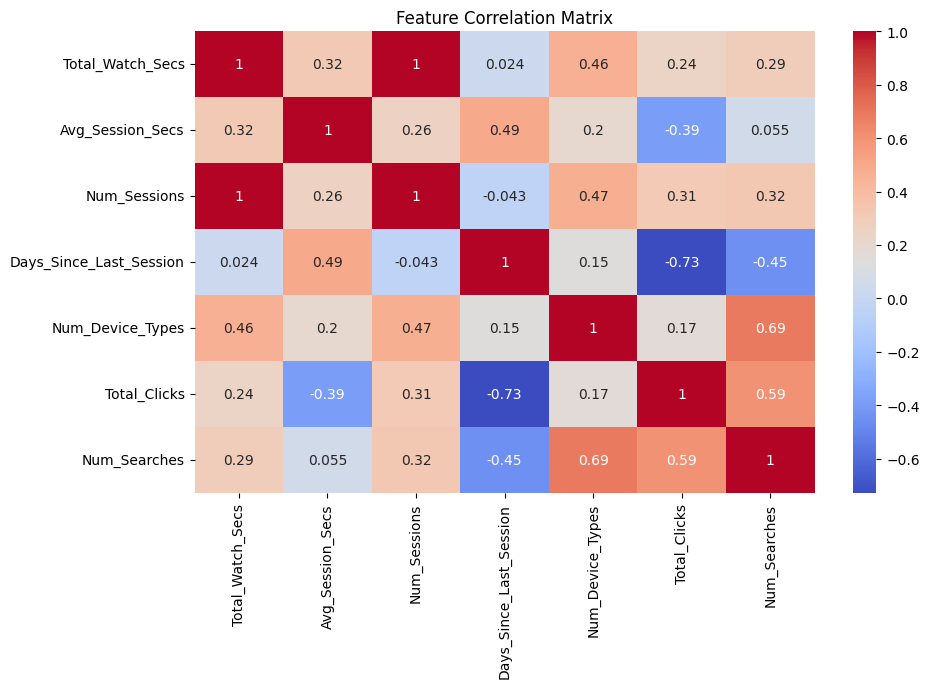

In [ ]:
plt.figure(figsize=(10,6))
sns.heatmap(
    user_master[['Total_Watch_Secs', 'Avg_Session_Secs', 'Num_Sessions',
                 'Days_Since_Last_Session', 'Num_Device_Types', 'Total_Clicks', 'Num_Searches']]
    .corr(), annot=True, cmap='coolwarm'
)
plt.title('Feature Correlation Matrix')
plt.show()


Watch-Time Distribution & Outlier Flag

Why? Surface abnormal (>99.5 %) durations that might indicate logging issues or account sharing.

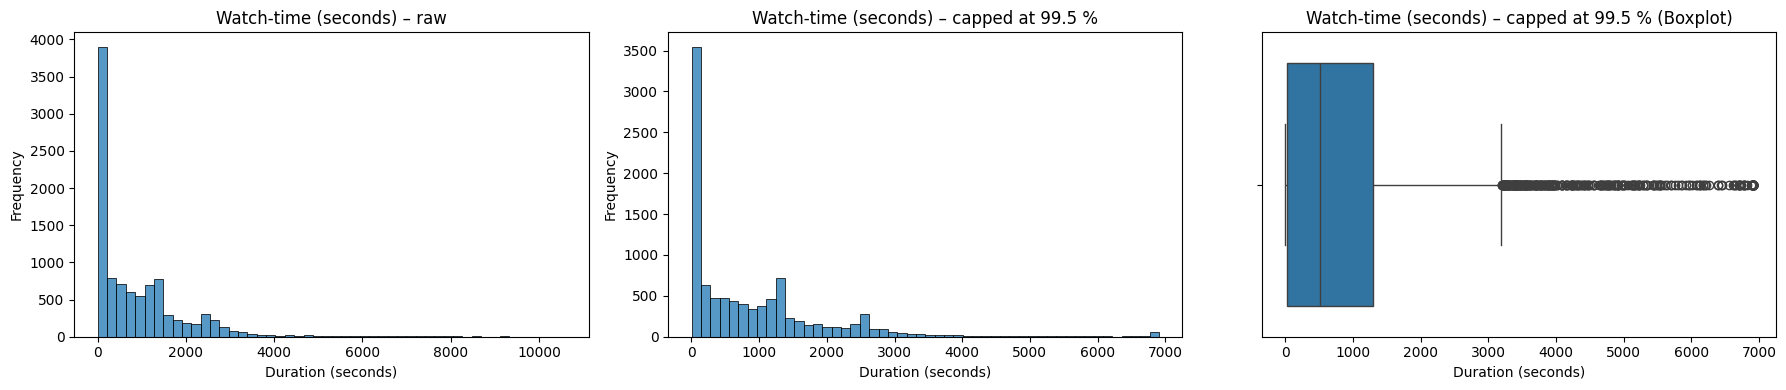

50 extreme sessions flagged as potential anomalies


In [ ]:
# Convert 'Duration' to total seconds
view_cleaned_again['duration_seconds'] = pd.to_timedelta(view_cleaned_again['Duration']).dt.total_seconds()

dur = view_cleaned_again['duration_seconds'].dropna()

fig, ax = plt.subplots(1, 3, figsize=(18, 4)) # Adjusted for an additional plot

# Histogram for raw data
sns.histplot(dur, bins=50, ax=ax[0])
ax[0].set_title("Watch-time (seconds) – raw")
ax[0].set_xlabel("Duration (seconds)")
ax[0].set_ylabel("Frequency")

# Histogram for capped data
clip = dur.clip(upper=dur.quantile(0.995))
sns.histplot(clip, bins=50, ax=ax[1])
ax[1].set_title("Watch-time (seconds) – capped at 99.5 %")
ax[1].set_xlabel("Duration (seconds)")
ax[1].set_ylabel("Frequency")

# Boxplot for capped data to show distribution and outliers
sns.boxplot(x=clip, ax=ax[2])
ax[2].set_title("Watch-time (seconds) – capped at 99.5 % (Boxplot)")
ax[2].set_xlabel("Duration (seconds)")


plt.tight_layout() # Adjust layout to prevent overlapping titles/labels
plt.show()

outliers = view_cleaned_again[view_cleaned_again['duration_seconds'] > dur.quantile(0.995)]
print(f"{len(outliers):,} extreme sessions flagged as potential anomalies")

The initial analysis revealed a highly right-skewed distribution, where a small number of extreme outliers (very long watch sessions) distorted the overall picture. To create a more accurate representation of typical user behavior, the data was preprocessed by capping the watch-time at the 99.5th percentile. This outlier handling technique produced a cleaner, more representative dataset, which is essential for accurate feature engineering and subsequent modeling stages.

Hour-of-Day × Day-of-Week Heat-map

Why? Identify peak engagement windows for capacity-planning and in-app promo

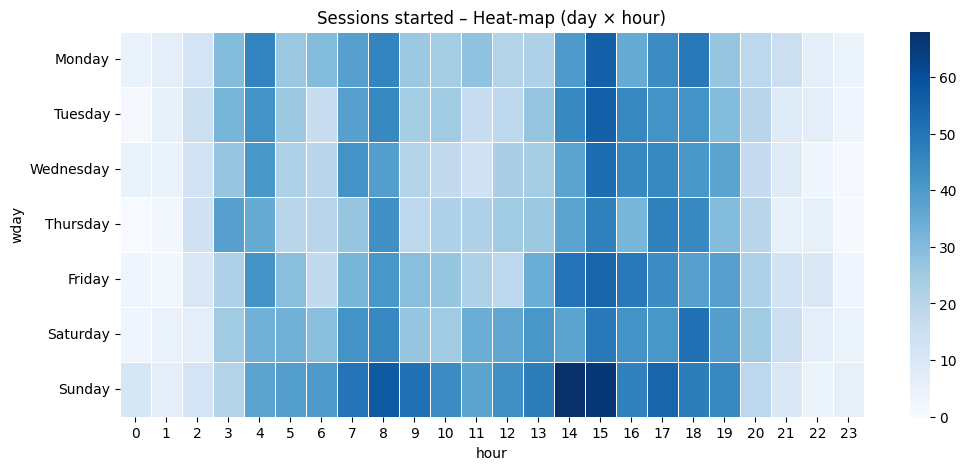

In [ ]:
# Rename columns to match the original code's expectations
view_cleaned_again = view_cleaned_again.rename(columns={'Start Time': 'timestamp'})

# Convert 'timestamp' to datetime with UTC timezone and then convert to UTC
view_cleaned_again['timestamp'] = pd.to_datetime(view_cleaned_again['timestamp'], utc=True).dt.tz_convert('UTC')

# Sort the dataframe by user and timestamp
view_cleaned_again = view_cleaned_again.sort_values(['Profile Name','timestamp'])

# Calculate the time difference between consecutive events for each user in minutes
view_cleaned_again['gap_min'] = view_cleaned_again.groupby('Profile Name')['timestamp'].diff().dt.total_seconds().div(60)

# Create a session_id based on a gap of more than 30 minutes or the start of a new user's events
view_cleaned_again['session_id'] = (view_cleaned_again['gap_min'].gt(30) | view_cleaned_again['gap_min'].isna()).groupby(view_cleaned_again['Profile Name']).cumsum()

# Extract hour and weekday from the timestamp
view_cleaned_again['hour'] = view_cleaned_again['timestamp'].dt.hour
view_cleaned_again['wday'] = view_cleaned_again['timestamp'].dt.day_name()

# Group by weekday and hour to count unique sessions
heat = (view_cleaned_again.groupby(['wday','hour'])['session_id']
              .nunique()
              .unstack(fill_value=0)
              .loc[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']])

plt.figure(figsize=(12,5))
sns.heatmap(heat, cmap="Blues", linewidths=.5)
plt.title("Sessions started – Heat-map (day × hour)")
plt.show()

Device × Country Matrix

Why? Spot mismatches (e.g. low Connected-TV share in regions you expect to dominate TV usage).

In [ ]:
import re
import pandas as pd

# ------------------------------------------------------------------
# 1.  Build a clean “device_code” integer column
# ------------------------------------------------------------------
def add_device_code(df, raw_col="device_type"):
    """
    Extract the trailing integer from strings like 'Device Type 4'
    and store it in df['device_code'] as an int (nullable Int64).
    """
    if raw_col not in df.columns:
        raise KeyError(f"{raw_col} column not found!")

    # grab the first integer in the string
    df["device_code"] = (
        df[raw_col]
        .astype(str)
        .str.extract(r"(\d+)", expand=False)   # returns NaN if not found
        .astype("Int64")                       # pandas nullable int
    )
    return df

# ------------------------------------------------------------------
# 2.  Map code → broad device_group
# ------------------------------------------------------------------
DEVICE_CODE_MAP = {
     0: "Mobile iOS",
     1: "Mobile Android",
     2: "Connected TV",
     3: "Connected TV",
     4: "Desktop/Web",
     5: "Desktop/Web",
     6: "Mobile Android",
     7: "Connected TV",
     8: "Mobile iOS",
     9: "Desktop/Web",
    10: "Other",          # consoles etc.
    11: "Other",
}

def add_device_group(df, code_col="device_code"):
    """
    Map numeric device_code to the five broad buckets.
    """
    if code_col not in df.columns:
        raise KeyError(f"{code_col} column not found—run add_device_code first")

    df["device_group"] = df[code_col].map(DEVICE_CODE_MAP).fillna("Other")
    return df

# ------------------------------------------------------------------
# 3.  One-liner helper you can call in your pipeline
# ------------------------------------------------------------------
def map_device_group(df, raw_col="device_type"):
    """
    Full mapping: extract code -> map group -> return df
    """
    df = add_device_code(df, raw_col=raw_col)
    df = add_device_group(df, code_col="device_code")
    return df

# ------------------------------------------------------------------
# 4.  Apply + sanity check
# ------------------------------------------------------------------
devices = map_device_group(devices, raw_col="Device Type")

# Quick check -- every unique raw value and its mapped group
check = (
    devices[["Device Type", "device_code", "device_group"]]
    .drop_duplicates()
    .sort_values("device_code")
    .reset_index(drop=True)
)
print("\n=== Mapping check ===")
print(check)

# Optional: frequency table
freq = (
    devices.groupby(["device_code", "device_group"])
           .size()
           .rename("rows")
           .reset_index()
           .sort_values("rows", ascending=False)
)
print("\n=== Row counts by code/group ===")
print(freq.head(20))


=== Mapping check ===
       Device Type  device_code    device_group
0    Device Type 0            0      Mobile iOS
1    Device Type 1            1  Mobile Android
2    Device Type 2            2    Connected TV
3    Device Type 3            3    Connected TV
4    Device Type 4            4     Desktop/Web
5    Device Type 5            5     Desktop/Web
6    Device Type 6            6  Mobile Android
7    Device Type 7            7    Connected TV
8    Device Type 8            8      Mobile iOS
9    Device Type 9            9     Desktop/Web
10  Device Type 10           10           Other
11  Device Type 11           11           Other

=== Row counts by code/group ===
    device_code    device_group  rows
0             0      Mobile iOS    43
1             1  Mobile Android    39
2             2    Connected TV     9
3             3    Connected TV     9
4             4     Desktop/Web     7
5             5     Desktop/Web     7
6             6  Mobile Android     6
7             7

In [ ]:
# Merge user_master with the devices table including the mapped device_group
user_master_with_devices = user_master.merge(devices[['Profile Name', 'device_group', 'Device Type']], on='Profile Name', how='left')

# Display the first few rows of the merged dataframe
display(user_master_with_devices.head())

,Profile Name,Profile Creation Time,Maturity Level,Primary Lang,Has Auto Playback,Max Stream Quality,Profile Lock Enabled,Profile Transferred,Opt-Out,Privacy And Data Settings,...,Last_Session,Days_Since_Last_Session,Num_Device_Types,Num_Devices,Total_Clicks,Unique_Nav_Levels,Num_Searches,Unique_Queries,device_group,Device Type
0,User 0,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN,...,2022-10-06 17:29:04,257,7,10,933,14,18,7,Mobile iOS,Device Type 0
1,User 0,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN,...,2022-10-06 17:29:04,257,7,10,933,14,18,7,Desktop/Web,Device Type 4
2,User 0,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN,...,2022-10-06 17:29:04,257,7,10,933,14,18,7,Mobile iOS,Device Type 0
3,User 0,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN,...,2022-10-06 17:29:04,257,7,10,933,14,18,7,Connected TV,Device Type 2
4,User 0,2021-10-29 05:42:00,ADULTS,en-IN,1.0,Unknown,False,False,{},NaN,...,2022-10-06 17:29:04,257,7,10,933,14,18,7,Mobile iOS,Device Type 0


Device Type_x,Device Type 0,Device Type 1,Device Type 10,Device Type 11,Device Type 2,Device Type 3,Device Type 4,Device Type 5,Device Type 6,Device Type 7,Device Type 8,Device Type 9
Country,,,,,,,,,,,,
AE (United Arab Emirates),0.125000,0.125000,0.000000,0.000000,0.125000,0.125000,0.125000,0.125000,0.062500,0.125000,0.062500,0.000000
CA (Canada),0.125000,0.125000,0.000000,0.000000,0.125000,0.125000,0.125000,0.125000,0.062500,0.125000,0.062500,0.000000
CR (Costa Rica),0.111111,0.111111,0.000000,0.000000,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.000000
FR (France),0.125000,0.125000,0.000000,0.000000,0.125000,0.125000,0.125000,0.125000,0.062500,0.125000,0.062500,0.000000
GB (United Kingdom),0.111111,0.111111,0.000000,0.000000,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.000000
IN (India),0.145161,0.145161,0.016129,0.032258,0.112903,0.096774,0.112903,0.112903,0.064516,0.096774,0.032258,0.032258
MT (Malta),0.111111,0.111111,0.000000,0.000000,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.000000
SK (Slovakia),0.111111,0.111111,0.000000,0.000000,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.000000
"TW (Taiwan, Province of China)",0.111111,0.111111,0.000000,0.000000,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.111111,0.000000


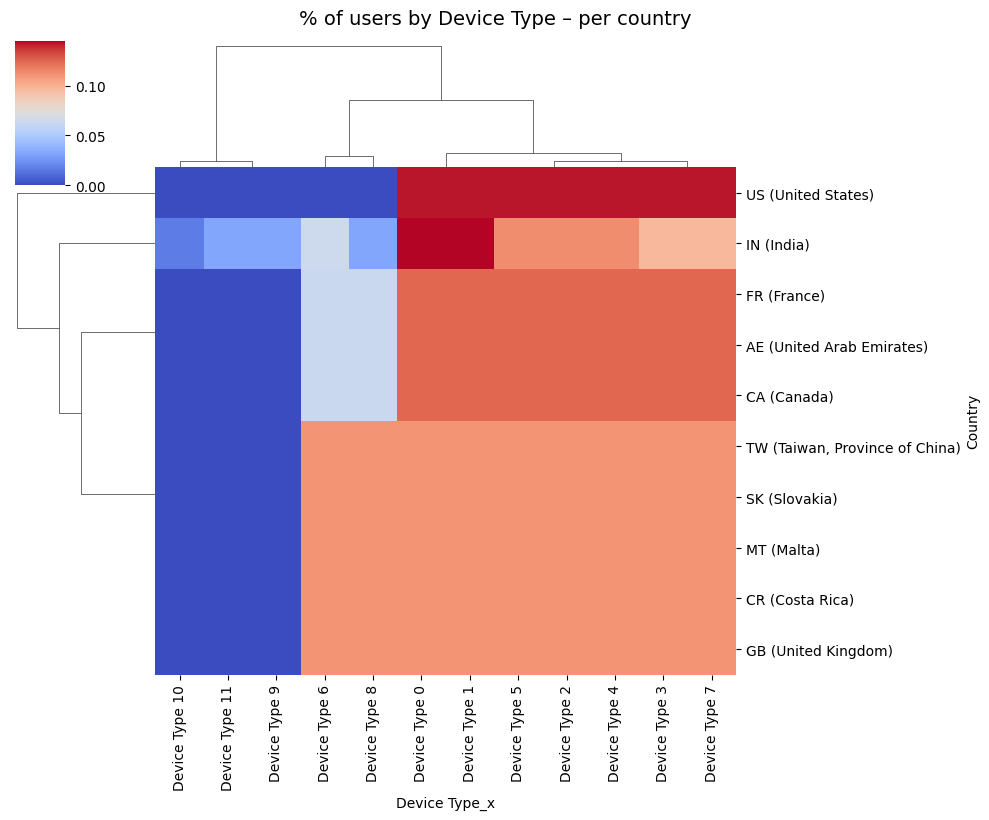

In [ ]:
# Merge devices and view dataframes on 'Profile Name'
merged_devices_view = devices.merge(view, on='Profile Name', how='left')

# Define the desired order for Device Types (using the original column values)
# Assuming the unique values in 'Device Type_x' are representative and can be ordered
device_order = merged_devices_view['Device Type_x'].dropna().unique().tolist()
device_order.sort() # Attempt to sort for some consistency, adjust if a specific order is needed

# Calculate the percentage of unique profiles by Device Type per country
mat = (merged_devices_view
       .dropna(subset=['Device Type_x','Country']) # Use 'Device Type_x'
       .groupby(['Country','Device Type_x'])['Profile Name'] # Use 'Device Type_x'
       .nunique()
       .pipe(lambda t: t/t.groupby(level=0).sum())   # row-wise %
       .unstack(fill_value=0)
       .reindex(columns=device_order, fill_value=0) # Reindex with Device Type_x values
       .sort_index())

display(mat.head(10))

# --- choose viz depending on matrix size ---------------------------------
import seaborn as sns
import matplotlib.pyplot as plt

title = "% of users by Device Type – per country"

if mat.shape[0] >= 2 and mat.shape[1] >= 2:
    # enough data for clustering
    cg = sns.clustermap(mat, cmap="coolwarm",
                        metric="euclidean", figsize=(10, 8))
    cg.fig.suptitle(title, y=1.02, fontsize=14)
else:
    # fallback: simple heat-map
    plt.figure(figsize=(6, 4))
    sns.heatmap(mat, annot=True, fmt=".0%", cmap="coolwarm")
    plt.title(title)
    plt.tight_layout()

plt.show()

Correlation Between Search Frequency & Watch Time

Why? Gauge whether search actually drives engagement (or only power users search).

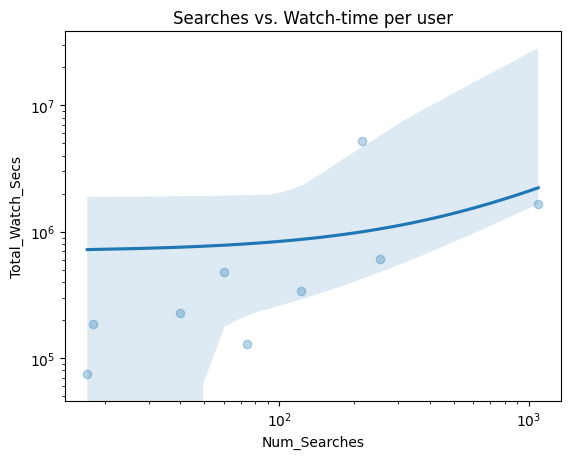

                  Num_Searches  Total_Watch_Secs
Num_Searches          1.000000          0.816667
Total_Watch_Secs      0.816667          1.000000


In [ ]:
tmp = user_master[['Num_Searches','Total_Watch_Secs']].dropna()
sns.regplot(data=tmp, x='Num_Searches', y='Total_Watch_Secs', scatter_kws={'alpha':0.3})
plt.xscale('log'); plt.yscale('log')
plt.title("Searches vs. Watch-time per user")
plt.show()

print(tmp.corr(method='spearman'))

Top 10 Titles per Device Group

Why? Show product & marketing which content pops on each screen.

In [ ]:
# Merge view_cleaned_again with devices to get device_group information
view_with_device_group = view_cleaned_again.merge(devices[['Profile Name', 'device_group']], on='Profile Name', how='left')

top_titles = (view_with_device_group.groupby(['device_group','Title'])['Profile Name']
                    .nunique()
                    .reset_index()
                    .sort_values(['device_group','Profile Name'], ascending=[True,False])
                    .groupby('device_group')
                    .head(10))

for g in top_titles['device_group'].unique():
    print(f"\n### {g}")
    print(top_titles.query('device_group==@g')[['Title','Profile Name']]
          .rename(columns={'Profile Name':'unique_viewers'}))


### Connected TV
                       Title  unique_viewers
2256             Night Drive               6
653              Dear Friend               5
737           Doctor (Tamil)               5
769   Etharkkum Thunindhavan               5
1392                  Kaaval               5
1514       Kurup (Malayalam)               5
1794           Minnal Murali               5
2438              Red Notice               5
471         CBI 5: The Brain               4
1135            Hey Sinamika               4

### Desktop/Web
                       Title  unique_viewers
6356             Night Drive               6
4753             Dear Friend               5
4837          Doctor (Tamil)               5
4869  Etharkkum Thunindhavan               5
5492                  Kaaval               5
5614       Kurup (Malayalam)               5
5894           Minnal Murali               5
6538              Red Notice               5
4571        CBI 5: The Brain               4
5235            Hey 

In [ ]:
# Recreate device_group column in the original devices DataFrame
devices = map_device_group(devices, raw_col="Device Type")

# Generate and display the mapping table from the original devices DataFrame
original_mapping_table = (
    devices[['Device Type', 'device_group']]
        .drop_duplicates()
        .sort_values('Device Type')
        .reset_index(drop=True)
)
display(original_mapping_table)

,Device Type,device_group
0,Device Type 0,Mobile iOS
1,Device Type 1,Mobile Android
2,Device Type 10,Other
3,Device Type 11,Other
4,Device Type 2,Connected TV
5,Device Type 3,Connected TV
6,Device Type 4,Desktop/Web
7,Device Type 5,Desktop/Web
8,Device Type 6,Mobile Android
9,Device Type 7,Connected TV


In [ ]:
# ---------------------------------------------------------------
#  Top-10 titles for every numeric device_type (0-11)
# ---------------------------------------------------------------

# Use view_cleaned_again for analysis
# Ensure 'Profile Name' is the user identifier and 'Title' is the content identifier
# Ensure 'Device Type' is the column containing device type information

# 1)  Make sure we have a clean integer code column
# This step was performed earlier using map_device_group function on 'devices' dataframe.
# We need to merge device code information into view_cleaned_again.
# However, based on the previous attempts, it's simpler to use the original 'Device Type' column from view_cleaned_again
# and group by that directly, as the requirement is top titles per *device type*, not device code.


# 2)  Compute unique-viewer counts
top_titles_per_type = (
    view_cleaned_again.groupby(["Device Type", "Title"])["Profile Name"]
         .nunique()                         # unique viewers per title
         .reset_index(name="unique_viewers")
         .sort_values(["Device Type", "unique_viewers"], ascending=[True, False])
         .groupby("Device Type")
         .head(10)                          # top-10 for each type
)

# 3)  Pretty-print
for device_type in sorted(top_titles_per_type["Device Type"].dropna().unique()):
    print(f"\n### {device_type}")
    display(
        top_titles_per_type
          .query("`Device Type` == @device_type")[["Title", "unique_viewers"]] # Use 'Title' and 'Device Type'
          .reset_index(drop=True)
    )

# (Optional) save to CSV
# top_titles_per_type.to_csv("/mnt/data/top10_titles_per_device_type.csv", index=False)


### Device Type 0


,Title,unique_viewers
0,Never Have I Ever: Season 1: Pilot (Episode 1),4
1,Doctor (Tamil),3
2,Hey Sinamika,3
3,Jana Gana Mana,3
4,KD (A) Karuppudurai,3
5,Kurup (Malayalam),3
6,Kuttavum Shikshayum,3
7,Minnal Murali,3
8,"Never Have I Ever: Season 1: ... been a big, f...",3
9,Never Have I Ever: Season 1: ... been the lone...,3



### Device Type 1


,Title,unique_viewers
0,Breaking Bad: Season 3: Kafkaesque (Episode 9),4
1,Cinemagraph: SpongeBob: Get Cooking,3
2,Gatta Kusthi,3
3,Jana Gana Mana,3
4,Jaoon Kahan Bata Ae Dil,3
5,Kumari,3
6,12 Strong,2
7,3 Idiots,2
8,Ayalvaashi,2
9,Ayalvaashi_hook_primary_16x9,2



### Device Type 11


,Title,unique_viewers
0,Anacondas: The Hunt for the Blood Orchid_hook_...,1
1,Annabelle: Creation,1
2,Ariyippu/Declaration,1
3,Attention Please,1
4,Attention Please_hook_02_16x9,1
5,BLACKPINK: Light Up the Sky,1
6,Bhool Bhulaiyaa 2,1
7,Boys Over Flowers: Volume 1: Episode 1,1
8,Bram Stoker's Dracula,1
9,Chhota Bheem: Season 15: Episode 1,1



### Device Type 2


,Title,unique_viewers
0,2 Hearts_hook_01_16x9,1
1,Anna_hook_01_16x9,1
2,Ante Sundaraniki (Malayalam)_hook_05_16x9,1
3,Asura Guru,1
4,Asura Guru_hook_primary_16x9,1
5,B.A. Pass 2,1
6,Bangistan,1
7,Batman v Superman: Dawn of Justice_hook_primar...,1
8,Bhool Bhulaiyaa 2,1
9,Blackhat_hook_primary_16x9,1



### Device Type 3


,Title,unique_viewers
0,La Casa de Papel: Part 5: Tokio Rekindles With...,1
1,Naruto: Season 9: The Village of Artisans: Dep...,1
2,Naruto: Season 9: The Village of Artisans: The...,1
3,Never Have I Ever: Season 1: Pilot (Episode 1),1
4,Shutter Island_hook_primary_16x9,1
5,The Conjuring 2,1
6,The Departed_hook_primary_16x9,1
7,The Twilight Saga: Breaking Dawn: Part 2_hook_...,1
8,Untitled Tentpole Title (Tamil)_hook_primary_16x9,1
9,Venom: Let There Be Carnage_hook_03_16x9,1



### Device Type 4


,Title,unique_viewers
0,Etharkkum Thunindhavan,2
1,Gangubai Kathiawadi_hook_primary_16x9,2
2,Kurup_hook_05_16x9,2
3,Night Drive,2
4,365 Days,1
5,365 Days: This Day,1
6,365 Days_hook_primary_16x9,1
7,A Journal for Jordan_hook_primary_16x9,1
8,A Quiet Place Part II,1
9,A Quiet Place Part II_hook_01_16x9,1



### Device Type 5


,Title,unique_viewers
0,Blade of Demon Destruction: Season 1_hook_prim...,2
1,Hunter X Hunter (2011): Season 1_hook_01_16x9,2
2,Hunter X Hunter (2011): Season 1_hook_primary_...,2
3,Inglourious Basterds_hook_primary_16x9,2
4,JoJo's Bizarre Adventure: Season 1_hook_primar...,2
5,Kuttavum Shikshayum_hook_primary_16x9,2
6,Moment of High Emotion Clip: Red Notice,2
7,Naruto Shippuden: Season 1_hook_02_16x9,2
8,Naruto: Season 1: Enter: Naruto Uzumaki! (Epis...,2
9,Naruto: Season 1_hook_primary_16x9,2



### Device Type 6


,Title,unique_viewers
0,Vaashi (Malayalam)_hook_01_16x9,2
1,Ayalvaashi,1
2,Ayalvaashi_hook_primary_16x9,1
3,Bhool Bhulaiya 2_hook_04_16x9,1
4,CBI 5: The Brain,1
5,CBI 5: The Brain (Malayalam)_hook_primary_16x9,1
6,Charlie and the Chocolate Factory_hook_primary...,1
7,Don't Look Up,1
8,Genre Specific Moment Clip: Darlings,1
9,Kaaval,1



### Device Type 7


,Title,unique_viewers
0,Boomika (Malayalam)_hook_01_16x9,2
1,Doctor (Tamil),2
2,Minnal Murali,2
3,2012_hook_primary_16x9,1
4,A Star Shoots across the Sky_hook_02_16x9,1
5,Action Hero_hook_primary_16x9,1
6,Ala Vaikunthapurramuloo,1
7,Anacondas: The Hunt for the Blood Orchid,1
8,Anbe Sivam_hook_01_16x9,1
9,Angu Vaikuntapurathu (Malayalam),1


/tmp/ipython-input-1226089681.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sub,
/tmp/ipython-input-1226089681.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sub,
/tmp/ipython-input-1226089681.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sub,
/tmp/ipython-input-1226089681.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=sub,


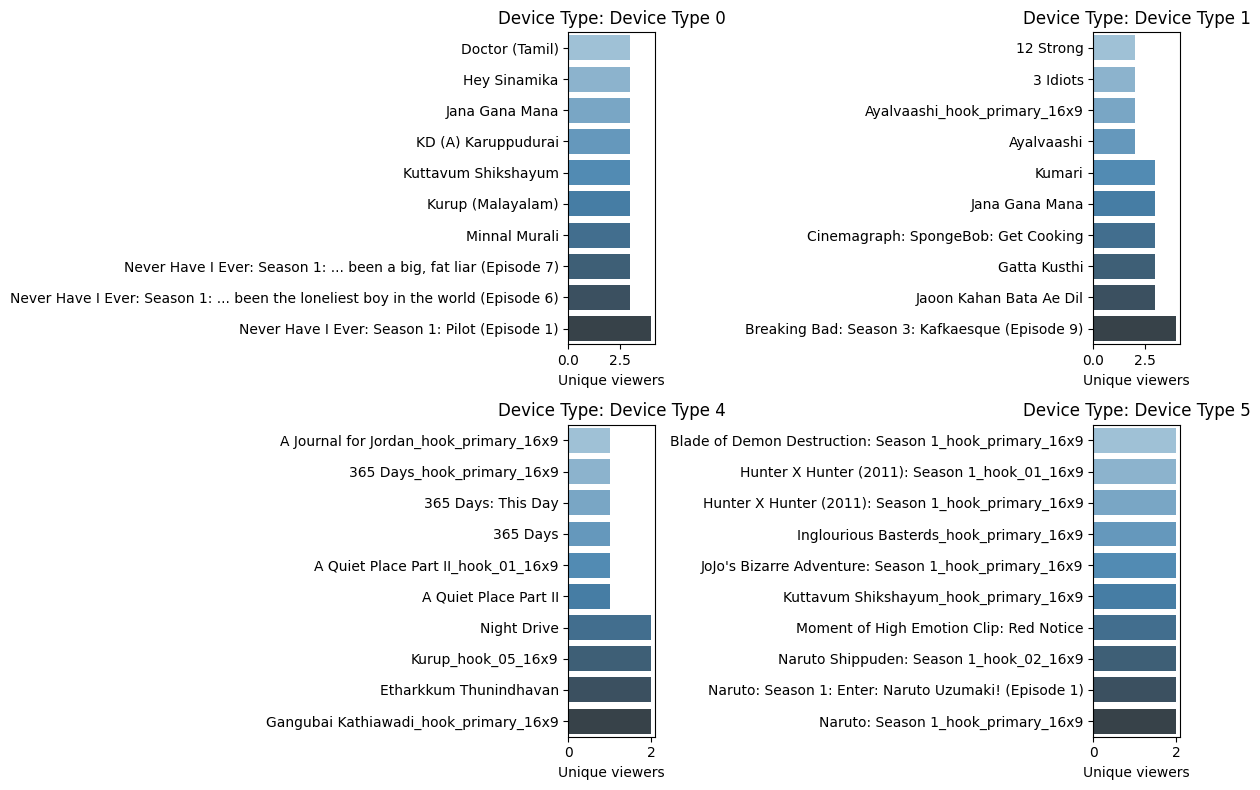

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# ──────────────────────────────────────────────
# Identify the top 4 devices based on total unique viewers
# ──────────────────────────────────────────────
top_devices = (top_titles_per_type.groupby('Device Type')['unique_viewers']
               .sum()
               .sort_values(ascending=False)
               .head(4)
               .index.tolist())

# Filter the top_titles_per_type DataFrame to include only the top 4 devices
top_titles_top_devices = top_titles_per_type[top_titles_per_type['Device Type'].isin(top_devices)]

# ──────────────────────────────────────────────
# 1.  Faceted bar charts (max 4×3 grid) for top 4 devices
# ──────────────────────────────────────────────
sorted_device_types  = sorted(top_devices) # Sort the top devices
n_device_types       = len(sorted_device_types)
n_cols        = 2                                # Adjust columns for better layout if needed (e.g., 2 columns for 4 devices)
n_rows        = -(-n_device_types // n_cols)            # ceiling division

fig, axes = plt.subplots(n_rows, n_cols,
                         figsize=(6*n_cols, 4*n_rows), # Adjust figsize
                         sharex=False)

# flatten axes for easy indexing
axes = axes.flatten()

for i, device_type in enumerate(sorted_device_types):
    ax  = axes[i]
    sub = (top_titles_top_devices # Use the filtered dataframe
           .query("`Device Type` == @device_type")
           .sort_values("unique_viewers", ascending=True))
    sns.barplot(data=sub,
                y="Title", x="unique_viewers",
                palette="Blues_d", ax=ax)
    ax.set_title(f"Device Type: {device_type}")
    ax.set_xlabel("Unique viewers")
    ax.set_ylabel("")

# Hide any unused subplot frames
for j in range(i+1, len(axes)):
    axes[j].set_visible(False)

plt.tight_layout()
plt.show()



# **User-Level Analysis**

/tmp/ipython-input-2117424892.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(


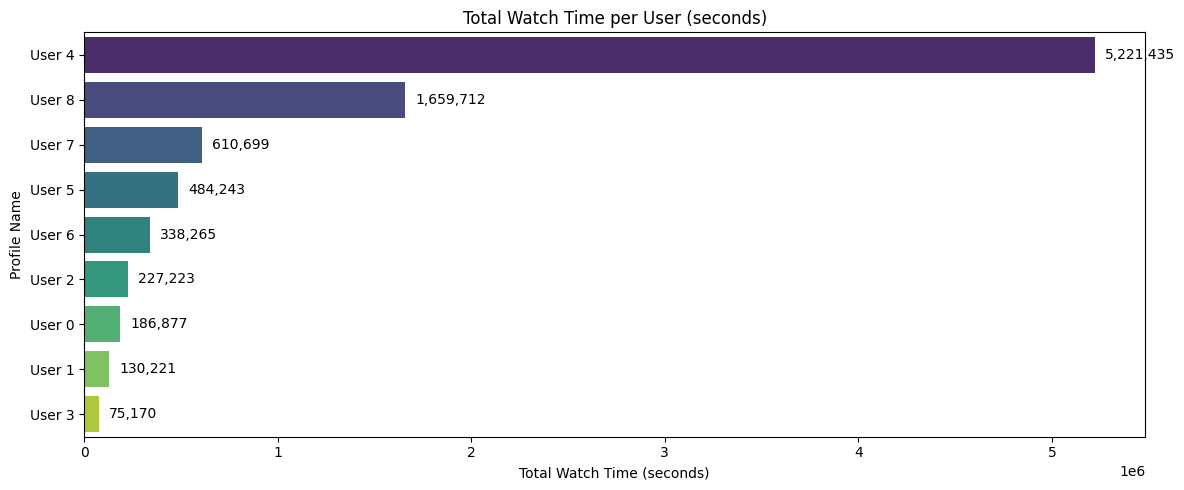

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# Sort users by total watch time
plot_df = user_master[['Profile Name', 'Total_Watch_Secs']].sort_values('Total_Watch_Secs', ascending=False)

plt.figure(figsize=(12, 5))
ax = sns.barplot(
    y='Profile Name',
    x='Total_Watch_Secs',
    data=plot_df,
    palette='viridis'
)
plt.xlabel('Total Watch Time (seconds)')
plt.ylabel('Profile Name')
plt.title('Total Watch Time per User (seconds)')

# Add exact value labels at the end of each bar
for i, (value, name) in enumerate(zip(plot_df['Total_Watch_Secs'], plot_df['Profile Name'])):
    ax.text(value + plot_df['Total_Watch_Secs'].max()*0.01, i, f"{int(value):,}", va='center', fontsize=10)

plt.tight_layout()
plt.show()


# **Session-gap analysis**

**Computes engagement metrics with features such as (recency, watch intensity, device signals).**

In [ ]:
# Find which users are only in search, only in viewing, or in both
users_view = set(view_cleaned_again['Profile Name'].unique())
users_search = set(search_cleaned_again['Profile Name'].unique())

print("Users in Viewing only:", users_view - users_search)
print("Users in Search only:", users_search - users_view)
print("Users in BOTH:", users_view & users_search)

Users in Viewing only: set()
Users in Search only: set()
Users in BOTH: {'User 8', 'User 3', 'User 5', 'User 6', 'User 2', 'User 0', 'User 1', 'User 4', 'User 7'}


**Calculating the gap between sessions for every user enables us to measure user engagement and behavioral patterns—such as binge-watching versus casual, infrequent usage. These metrics are crucial for predicting retention, identifying churn risk, and understanding what drives high-value users.**

In [ ]:
import pandas as pd

# Ensure correct datetime
view_cleaned_again['timestamp'] = pd.to_datetime(view_cleaned_again['timestamp'])

# Calculate session gap for ALL users
view_cleaned_again = view_cleaned_again.sort_values(['Profile Name', 'timestamp'])
view_cleaned_again['Gap_Hours'] = (
    view_cleaned_again.groupby('Profile Name')['timestamp'].diff().dt.total_seconds() / 3600
)

# Display one (or a few) sessions for each user
display(
    view_cleaned_again.groupby('Profile Name').head(3)[['Profile Name', 'Device Type', 'Title', 'Gap_Hours']]
)

,Profile Name,Device Type,Title,Gap_Hours
5726,User 0,Device Type 7,The Walking Dead: Season 1: Days Gone Bye (Epi...,NaN
5725,User 0,Device Type 7,The Walking Dead: Season 1: Days Gone Bye (Epi...,2.673611
5724,User 0,Device Type 7,The Walking Dead: Season 1: Guts (Episode 2),0.353611
188,User 1,Device Type 1,Untitled Tentpole Title (Tamil)_hook_02_16x9,NaN
187,User 1,Device Type 1,Untitled Tentpole Title (Tamil)_hook_02_16x9,0.008611
186,User 1,Device Type 1,Trailer: Minnal Murali,0.030556
5924,User 2,Device Type 0,Don't Look Up,NaN
5923,User 2,Device Type 0,Don't Look Up,0.263889
5922,User 2,Device Type 0,Don't Look Up,0.612778
272,User 3,Device Type 0,Mowgli: Legend of the Jungle,NaN


Visualize Session Gap Distribution (Binge vs. Casual) for All Users

Definition:
Binge session: Gap < 2 hours
Casual session: Gap >= 2 hours

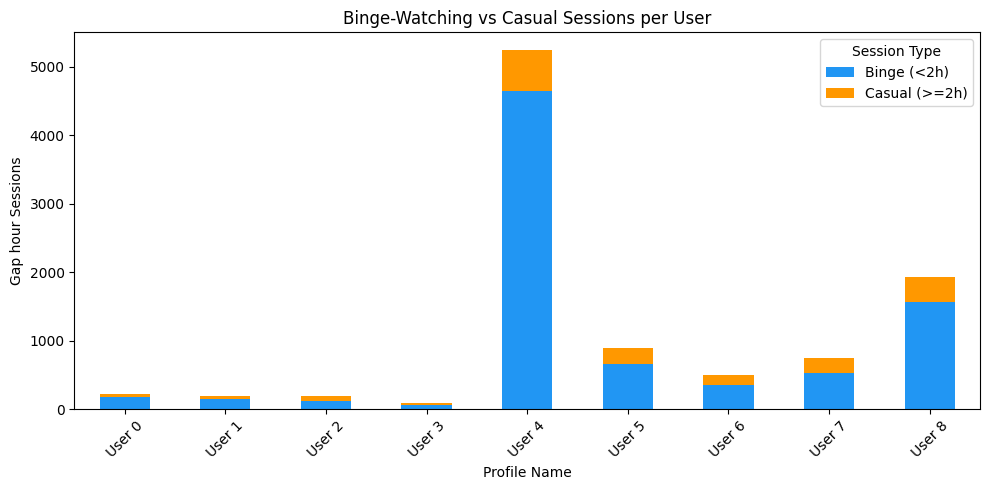

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Let's assume your session table is called 'view_sessions'
view_sessions = view_cleaned_again[['Profile Name', 'Gap_Hours']].copy()

# Binarize binge/casual
view_sessions['Session_Type'] = view_sessions['Gap_Hours'].apply(
    lambda x: 'Binge (<2h)' if pd.notnull(x) and x < 2 else 'Casual (>=2h)'
)

# Count per user
session_counts = view_sessions.groupby(['Profile Name', 'Session_Type']).size().unstack(fill_value=0)

# Stacked barplot
session_counts.plot(kind='bar', stacked=True, figsize=(10,5), color=['#2196f3', '#ff9800'])
plt.ylabel('Gap hour Sessions')
plt.title('Binge-Watching vs Casual Sessions per User')
plt.xticks(rotation=45)
plt.legend(title='Session Type')
plt.tight_layout()
plt.show()


In [ ]:
display(view_sessions)

,Profile Name,Gap_Hours,Session_Type
5726,User 0,NaN,Casual (>=2h)
5725,User 0,2.673611,Casual (>=2h)
5724,User 0,0.353611,Binge (<2h)
5723,User 0,3.157222,Casual (>=2h)
5722,User 0,859.897500,Casual (>=2h)
...,...,...,...
7172,User 8,58.582778,Casual (>=2h)
7171,User 8,8.784167,Casual (>=2h)
7170,User 8,0.005278,Binge (<2h)
7169,User 8,0.012500,Binge (<2h)


In [ ]:
display(view_user)

,Profile Name,Total_Watch_Secs,Avg_Session_Secs,Num_Sessions,First_Session,Last_Session,Days_Since_Last_Session
0,User 0,186877.0,869.195349,215,2021-10-30 03:03:59,2022-10-06 17:29:04,257
1,User 1,130221.0,689.000000,189,2021-12-08 14:39:26,2022-04-28 16:08:56,419
2,User 2,227223.0,1147.590909,198,2021-12-26 13:27:05,2022-06-15 15:14:06,371
3,User 3,75170.0,894.880952,84,2021-11-25 16:37:44,2022-11-07 12:57:43,226
4,User 4,5221435.0,996.647261,5239,2021-10-31 07:55:44,2022-09-30 14:54:39,264
5,User 5,484243.0,542.873318,892,2023-01-07 15:13:19,2023-06-20 15:09:20,1
6,User 6,338265.0,681.985887,496,2022-06-13 19:28:21,2023-06-19 04:44:39,2
7,User 7,610699.0,817.535475,747,2022-06-05 17:56:46,2023-06-20 10:14:25,1
8,User 8,1659712.0,859.064182,1932,2022-06-01 13:32:46,2023-06-20 16:09:32,1


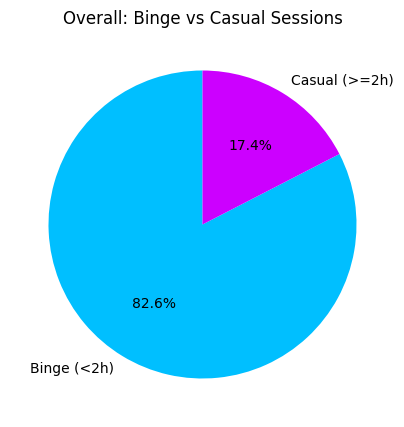

In [ ]:
counts = view_sessions['Session_Type'].value_counts()
plt.figure(figsize=(5,5))
counts.plot.pie(autopct='%1.1f%%', colors=['#00bfff', '#cc00ff'], startangle=90)
plt.ylabel('')
plt.title('Overall: Binge vs Casual Sessions')
plt.show()



**Key Metrics for Predicting Retention/Churn**

Compute for each user:

Avg Gap: Mean gap between sessions (hours)
Binge Rate: % of sessions that are binge (gap < 2h)
Max Gap: Longest inactivity (hours)
Num Sessions: Total sessions

In [ ]:
metrics = view_sessions.groupby('Profile Name').agg(
    Binge_Rate = ('Gap_Hours', lambda x: (x < 2).mean()),
    Avg_Gap = ('Gap_Hours', 'mean'),
    Max_Gap = ('Gap_Hours', 'max'),
    Num_Sessions = ('Gap_Hours', 'count')
)
display(metrics)


,Binge_Rate,Avg_Gap,Max_Gap,Num_Sessions
Profile Name,,,,
User 0,0.837209,38.310365,3393.444722,214
User 1,0.767196,18.007934,2319.750278,188
User 2,0.631313,20.841541,502.747778,197
User 3,0.642857,100.293169,2656.727500,83
User 4,0.885283,1.531688,214.663889,5238
User 5,0.736547,4.417434,241.937500,891
User 6,0.717742,17.958125,706.958333,495
User 7,0.714859,12.214872,1032.427500,746
User 8,0.807971,4.774010,344.258333,1931


In [ ]:
import pandas as pd

# Assume your aggregated table is view_user (with 'Profile Name' and 'Last_Session')
# Ensure 'Last_Session' is datetime
view_user['Last_Session'] = pd.to_datetime(view_user['Last_Session'])

# Set reference date as 1 day after the latest session in your data
reference_date = view_user['Last_Session'].max() + pd.Timedelta(days=1)

# Calculate days since each user's last session (as of reference date)
view_user['Recency_Days'] = (reference_date - view_user['Last_Session']).dt.days

# Sort users by recency (most recent = lowest value)
view_user_sorted = view_user.sort_values('Recency_Days')

# Display the table
display(view_user_sorted[['Profile Name', 'Last_Session', 'Recency_Days']])


,Profile Name,Last_Session,Recency_Days
7,User 7,2023-06-20 10:14:25,1
5,User 5,2023-06-20 15:09:20,1
8,User 8,2023-06-20 16:09:32,1
6,User 6,2023-06-19 04:44:39,2
3,User 3,2022-11-07 12:57:43,226
0,User 0,2022-10-06 17:29:04,257
4,User 4,2022-09-30 14:54:39,264
2,User 2,2022-06-15 15:14:06,371
1,User 1,2022-04-28 16:08:56,419


/tmp/ipython-input-2000689594.py:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


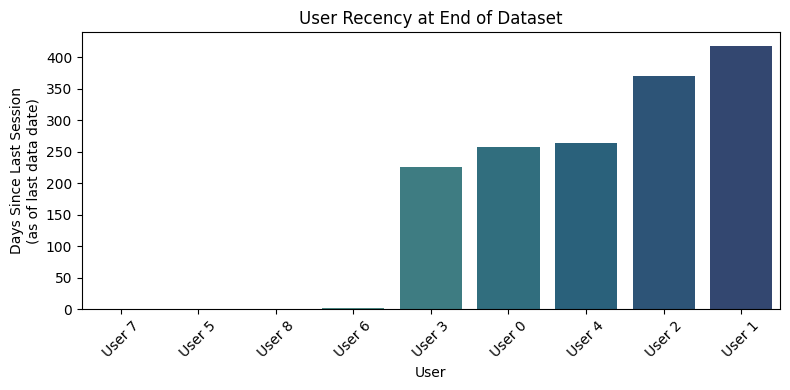

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(8,4))
sns.barplot(
    data=view_user_sorted,
    x='Profile Name', y='Recency_Days',
    palette='crest'
)
plt.ylabel('Days Since Last Session\n(as of last data date)')
plt.xlabel('User')
plt.title('User Recency at End of Dataset')
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()


**Merging search history with viewing sessions enables us to connect content discovery with consumption: we can determine whether searching for a title directly leads to watching it, how search activity impacts session timing, and whether certain users rely more on browsing or direct search to find content.**

In [ ]:
# Ensure correct datetime
search_cleaned_again['Utc Timestamp'] = pd.to_datetime(search_cleaned_again['Utc Timestamp'])
search_for_merge = search_cleaned_again.rename(columns={'Utc Timestamp': 'Start Time'})

# Ensure both dataframes are sorted by 'Profile Name' and 'Start Time' before merging
view_cleaned_again = view_cleaned_again.sort_values(['Profile Name', 'timestamp'])
search_for_merge = search_for_merge.sort_values(['Profile Name', 'Start Time'])

# Remove timezone information from 'timestamp' column in view_cleaned_again
view_cleaned_again['timestamp'] = view_cleaned_again['timestamp'].dt.tz_convert(None)


# Group by 'Profile Name' and apply merge_asof to each group
session_with_search_list = []
for profile_name, view_group in view_cleaned_again.groupby('Profile Name'):
    search_group = search_for_merge[search_for_merge['Profile Name'] == profile_name]
    if not search_group.empty:
        merged_group = pd.merge_asof(
            view_group,
            search_group,
            left_on='timestamp',
            right_on='Start Time',
            by='Profile Name',
            direction='nearest',
            allow_exact_matches=True
        )
        session_with_search_list.append(merged_group)

# Concatenate the results
session_with_search = pd.concat(session_with_search_list, ignore_index=True)


# Show 2 sessions per user (now with search columns)
display(
    session_with_search.groupby('Profile Name').head(3)[['Profile Name', 'Device Type', 'Displayed Name', 'Gap_Hours']]
)

,Profile Name,Device Type,Displayed Name,Gap_Hours
0,User 0,Device Type 7,Red Notice,NaN
1,User 0,Device Type 7,Red Notice,2.673611
2,User 0,Device Type 7,Red Notice,0.353611
215,User 1,Device Type 1,NaN,NaN
216,User 1,Device Type 1,NaN,0.008611
217,User 1,Device Type 1,NaN,0.030556
404,User 2,Device Type 0,Don't Look Up,NaN
405,User 2,Device Type 0,Don't Look Up,0.263889
406,User 2,Device Type 0,Don't Look Up,0.612778
602,User 3,Device Type 0,Jumanji: Welcome to the Jungle,NaN


**Search-to-Playback Lag KPI**

Are users who search hitting “Play” faster?

Median lag (min): 0.016666666666666666


Text(0.5, 1.0, 'Search → Playback Lag (minutes)')

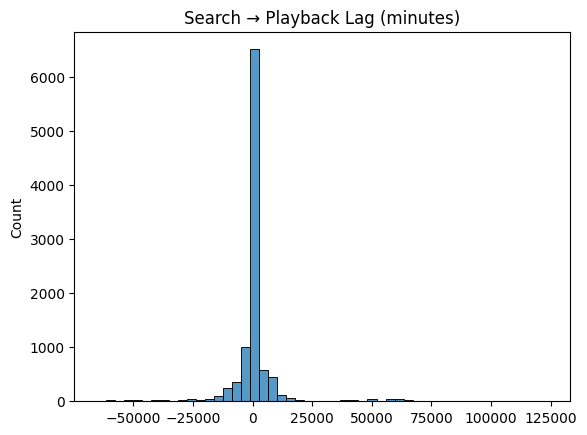

In [ ]:
lag = (session_with_search['timestamp'] -
       session_with_search['Start Time']).dt.total_seconds()/60   # minutes
lag = lag.dropna()

print("Median lag (min):", lag.median())
sns.histplot(lag, bins=50); plt.title("Search → Playback Lag (minutes)")

Search-to-Play Conversion Rate

For every search event, how often is a view launched within ±30 min?

In [ ]:
conv = session_with_search['Displayed Name'].notna().mean()
print(f"Search→Play conversion (±nearest) = {conv:.1%}")


Search→Play conversion (±nearest) = 64.4%


Title Discovery Mix

Which titles are 100 % “browsed” vs. mostly “searched”?

In [ ]:
title_mix = (session_with_search
             .assign(found_by_search=session_with_search['Start Time'].notna()) # Use 'Start Time' instead of 'Utc Timestamp'
             .groupby('Displayed Name')['found_by_search']
             .mean()
             .sort_values(ascending=False))

display(title_mix.head(15))            # most search-led titles
display(title_mix.tail(15))            # almost never searched

,found_by_search
Displayed Name,
"iZombie: Season 5: ""Thug Death""",1.0
Zindagi Na Milegi Dobara,1.0
Year One,1.0
We're the Millers,1.0
We Have a Ghost,1.0
"Vikings: Season 5: ""The Joke""",1.0
"Vikings: Season 5: ""Moments of Vision""",1.0
"Vikings: Season 5: ""Homeland""",1.0
"Vikings: Season 5: ""Full Moon""",1.0


,found_by_search
Displayed Name,
Addicted,1.0
Aaviri,1.0
ATHENA,1.0
A Wednesday,1.0
A Quiet Place Part II,1.0
A Perfect Pairing,1.0
A Babysitter's Guide to Monster Hunting,1.0
365 Days: This Day,1.0
365 Days,1.0


/tmp/ipython-input-855923023.py:18: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=top15.values, y=top15.index, palette="Blues_d")


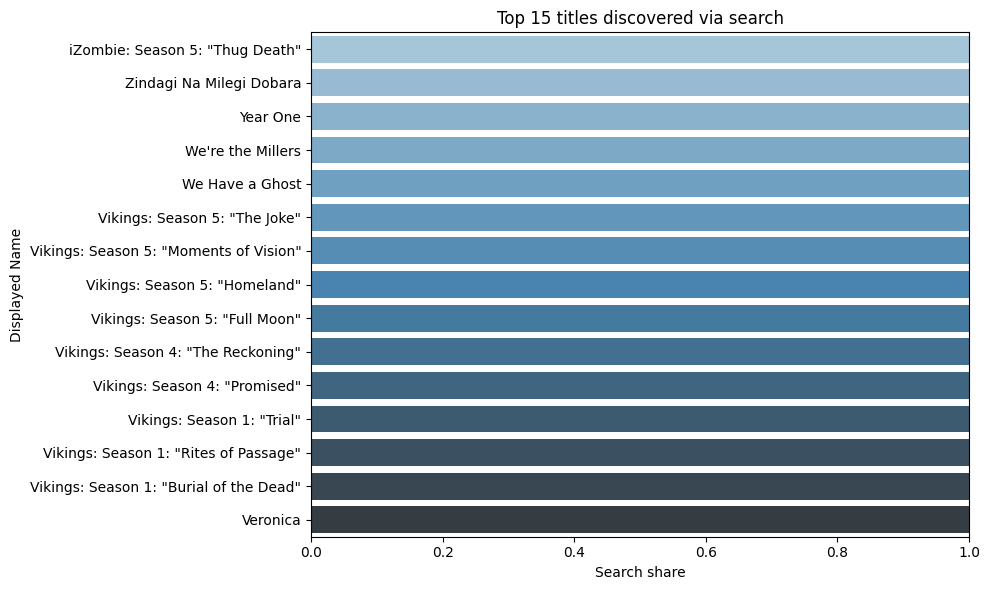

/tmp/ipython-input-855923023.py:30: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x=bot15.values, y=bot15.index, palette="Reds")


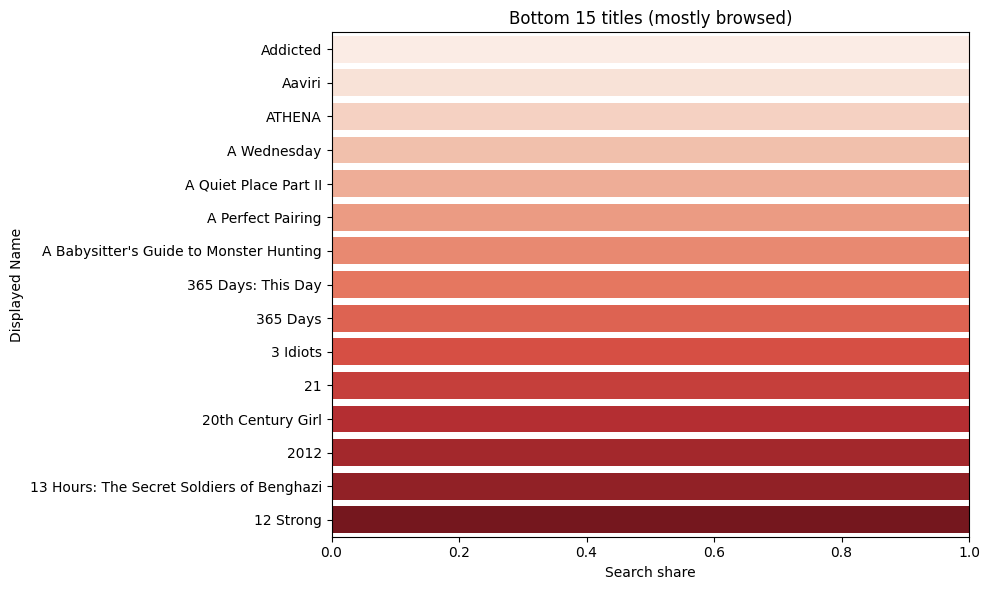

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

# -------------------------------------------------------------
#  A. Make sure `title_mix` exists (fraction search-led per title)
# -------------------------------------------------------------
title_mix = (session_with_search
             .assign(found_by_search=session_with_search['Start Time'].notna()) # Use 'Start Time' instead of 'Utc Timestamp'
             .groupby('Displayed Name')['found_by_search']
             .mean()
             .sort_values(ascending=False))

# -------------------------------------------------------------
#  C. Top 15 most search-led titles (bar)
# -------------------------------------------------------------
top15   = title_mix.head(15)
plt.figure(figsize=(10,6))
sns.barplot(x=top15.values, y=top15.index, palette="Blues_d")
plt.xlabel("Search share")
plt.title("Top 15 titles discovered via search")
plt.xlim(0,1)
plt.tight_layout()
plt.show()

# -------------------------------------------------------------
#  D. Bottom 15 (almost exclusively browsed)
# -------------------------------------------------------------
bot15   = title_mix.tail(15).sort_values()   # ascending
plt.figure(figsize=(10,6))
sns.barplot(x=bot15.values, y=bot15.index, palette="Reds")
plt.xlabel("Search share")
plt.title("Bottom 15 titles (mostly browsed)")
plt.xlim(0,1)
plt.tight_layout()
plt.show()

**This bubble plot visualizes user-level engagement patterns. Each point represents a user, positioned by the recency of their last session and total session count. Bubble size and color indicate total watch time in hours. Annotating user names enables easy identification of both power users and at-risk accounts, supporting targeted retention strategies.**

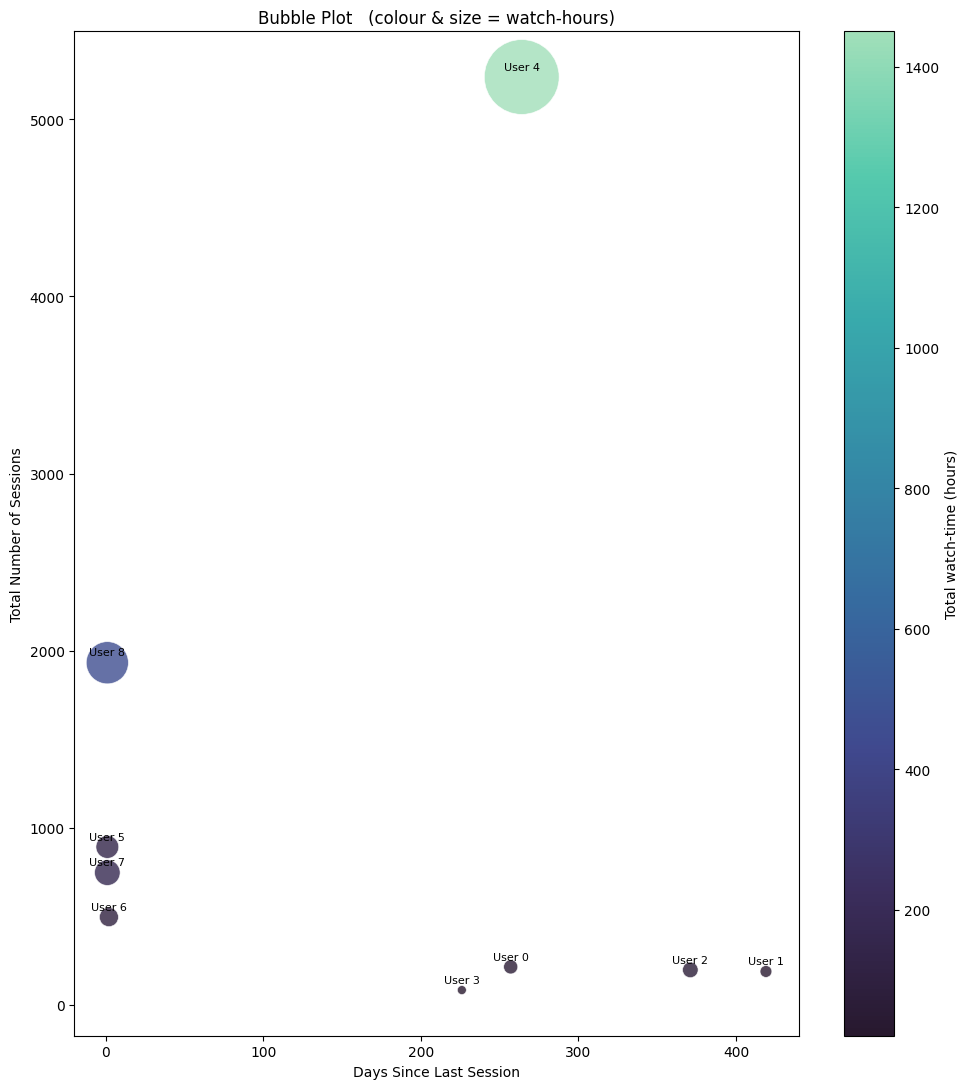


===  User-level engagement summary  ===
profile watch_hours sessions days_since
 User 4     1,450.4    5,239        264
 User 8       461.0    1,932          1
 User 7       169.6      747          1
 User 5       134.5      892          1
 User 6        94.0      496          2
 User 2        63.1      198        371
 User 0        51.9      215        257
 User 1        36.2      189        419
 User 3        20.9       84        226


In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import matplotlib.colors as mcolors
import numpy as np
import pandas as pd

# ────────────────────────────────────────────────
# A.  Core metrics
# ────────────────────────────────────────────────
user_master["watch_hours"] = user_master["Total_Watch_Secs"] / 3600

x = user_master["Days_Since_Last_Session"]
y = user_master["Num_Sessions"]
z = user_master["watch_hours"]                        # colour + size driver
s = z * 2                                            # bubble size  (scale factor)

# ────────────────────────────────────────────────
# B.  Distinct-looking *continuous* colour scale
#     • Build a LinearSegmentedColormap from a categorical
#       palette.
# ────────────────────────────────────────────────
base_pal  = sns.color_palette("mako", 8)             # 8 distinct colours
# Use LinearSegmentedColormap.from_list to create a continuous colormap
cmap = mcolors.LinearSegmentedColormap.from_list("my_cmap", base_pal)


norm      = mcolors.Normalize(vmin=z.min(), vmax=z.max())
sm        = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
sm.set_array([])                                     # required for colour-bar

# ────────────────────────────────────────────────
# C.  Bubble plot
# ────────────────────────────────────────────────
fig, ax = plt.subplots(figsize=(10, 11)) # Create figure and axes
scatter = ax.scatter( # Use ax.scatter instead of plt.scatter
    x, y, s=s, c=z, cmap=cmap, norm=norm,
    alpha=0.8, edgecolors="w", linewidth=0.5
)

ax.set_xlabel("Days Since Last Session") # Use ax.set_xlabel
ax.set_ylabel("Total Number of Sessions") # Use ax.set_ylabel
ax.set_title("Bubble Plot   (colour & size = watch-hours)") # Use ax.set_title

cbar = fig.colorbar(sm, ax=ax, label="Total watch-time (hours)") # Pass ax to colorbar

# annotate above each bubble
for _, row in user_master.iterrows():
    ax.text(row["Days_Since_Last_Session"], # Use ax.text
             row["Num_Sessions"] + 30,
             row["Profile Name"],
             ha="center", va="bottom", fontsize=8)

plt.tight_layout()
plt.show()

# ────────────────────────────────────────────────
# D.  Compact table of user-level watch-time
# ────────────────────────────────────────────────
tbl = (user_master[["Profile Name", "watch_hours",
                    "Num_Sessions", "Days_Since_Last_Session"]]
       .sort_values("watch_hours", ascending=False)
       .rename(columns={
           "Profile Name": "profile",
           "watch_hours":  "watch_hours",
           "Num_Sessions": "sessions",
           "Days_Since_Last_Session": "days_since"
       }))

print("\n===  User-level engagement summary  ===")
print(tbl.to_string(index=False, formatters={
    "watch_hours": lambda v: f"{v:,.1f}",
    "sessions"   : "{:,.0f}".format,
    "days_since" : "{:,.0f}".format
}))

In [ ]:
display(view_user)

,Profile Name,Total_Watch_Secs,Avg_Session_Secs,Num_Sessions,First_Session,Last_Session,Days_Since_Last_Session,Recency_Days
0,User 0,186877.0,869.195349,215,2021-10-30 03:03:59,2022-10-06 17:29:04,257,257
1,User 1,130221.0,689.000000,189,2021-12-08 14:39:26,2022-04-28 16:08:56,419,419
2,User 2,227223.0,1147.590909,198,2021-12-26 13:27:05,2022-06-15 15:14:06,371,371
3,User 3,75170.0,894.880952,84,2021-11-25 16:37:44,2022-11-07 12:57:43,226,226
4,User 4,5221435.0,996.647261,5239,2021-10-31 07:55:44,2022-09-30 14:54:39,264,264
5,User 5,484243.0,542.873318,892,2023-01-07 15:13:19,2023-06-20 15:09:20,1,1
6,User 6,338265.0,681.985887,496,2022-06-13 19:28:21,2023-06-19 04:44:39,2,2
7,User 7,610699.0,817.535475,747,2022-06-05 17:56:46,2023-06-20 10:14:25,1,1
8,User 8,1659712.0,859.064182,1932,2022-06-01 13:32:46,2023-06-20 16:09:32,1,1


In [ ]:
display(view_cleaned_again)

,Profile Name,timestamp,Duration,Attributes,Title,Supplemental Video Type,Device Type,Bookmark,Latest Bookmark,Country,duration_seconds,gap_min,session_id,hour,wday,Gap_Hours
5726,User 0,2021-10-30 03:03:59,00:25:22,Autoplayed: user action: User_Interaction;,The Walking Dead: Season 1: Days Gone Bye (Epi...,NaN,Device Type 7,00:25:49,Not latest view,IN (India),1522.0,NaN,1,3,Saturday,NaN
5725,User 0,2021-10-30 05:44:24,00:19:34,Autoplayed: user action: User_Interaction;,The Walking Dead: Season 1: Days Gone Bye (Epi...,NaN,Device Type 7,00:44:37,Not latest view,IN (India),1174.0,160.416667,2,5,Saturday,2.673611
5724,User 0,2021-10-30 06:05:37,00:40:54,Autoplayed: user action: User_Interaction;,The Walking Dead: Season 1: Guts (Episode 2),NaN,Device Type 7,00:42:16,Not latest view,IN (India),2454.0,21.216667,2,6,Saturday,0.353611
5723,User 0,2021-10-30 09:15:03,00:19:13,Autoplayed: user action: User_Interaction;,The Walking Dead: Season 1: Tell It to the Fro...,NaN,Device Type 7,00:23:29,Not latest view,IN (India),1153.0,189.433333,3,9,Saturday,3.157222
5722,User 0,2021-12-05 05:08:54,00:00:35,Autoplayed: user action: None;,Part 5 Volume 2 Villain / Antagonist Clip: La ...,HOOK,Device Type 7,00:00:35,00:00:35,IN (India),35.0,51593.850000,4,5,Sunday,859.897500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7172,User 8,2023-06-20 05:53:24,00:00:07,NaN,Never Have I Ever: Season 1 PVS Trailer A,TRAILER,Device Type 1,00:00:07,00:00:07,IN (India),7.0,3514.966667,704,5,Tuesday,58.582778
7171,User 8,2023-06-20 14:40:27,00:00:10,NaN,Vaashi (Malayalam)_hook_02_16x9,HOOK,Device Type 1,00:00:10,Not latest view,IN (India),10.0,527.050000,705,14,Tuesday,8.784167
7170,User 8,2023-06-20 14:40:46,00:00:43,NaN,Vaashi (Malayalam)_hook_02_16x9,HOOK,Device Type 1,00:00:42,00:00:42,IN (India),43.0,0.316667,705,14,Tuesday,0.005278
7169,User 8,2023-06-20 14:41:31,00:31:17,NaN,Vaashi,NaN,Device Type 1,00:31:09,Not latest view,IN (India),1877.0,0.750000,705,14,Tuesday,0.012500


# **Funnel Definition**

In [ ]:
# Let's use 'Source 0' as Group A, 'Source 1' as Group B (adapt as needed)
group_a = clicks_cleaned_again[clicks_cleaned_again['Source'] == 'Source 0']
group_b = clicks_cleaned_again[clicks_cleaned_again['Source'] == 'Source 1']

print(f"Group A size: {group_a['Profile Name'].nunique()} users")
print(f"Group B size: {group_b['Profile Name'].nunique()} users")

Group A size: 9 users
Group B size: 5 users


** Define Funnel Steps**

Can You Segment Users? (Cohorts, Groups, A/B)

In [ ]:
tables = {
    'profiles': profiles_cleaned_again,
    'devices': devices_cleaned_again,
    'clicks': clicks_cleaned_again,
    'search': search_cleaned_again,
    'view': view_cleaned_again
}

# What are possible cohort columns?
for dfname, df in tables.items():
    print(f"\n{dfname}:")
    for col in df.columns:
        if any(sub in col.lower() for sub in ['source', 'device', 'tier', 'plan', 'subscription']):
            print(f"  - {col}: {df[col].unique()[:10]}")


profiles:

devices:
  - Device Type: ['Device Type 4' 'Device Type 0' 'Device Type 5' 'Device Type 1'
 'Device Type 2' 'Device Type 6' 'Device Type 3' 'Device Type 7'
 'Device Type 8' 'Device Type 9']

clicks:
  - Source: ['Source 0' 'Source 1' 'Source 2']

search:
  - Device: ['Device 0' 'Device 2' 'Device 3' 'Device 1' 'Device 4' 'Device 5']

view:
  - Device Type: ['Device Type 7' 'Device Type 1' 'Device Type 0' 'Device Type 6'
 'Device Type 4' 'Device Type 5' 'Device Type 2' 'Device Type 3'
 'Device Type 11']


Navigation Level
browseTitles                    3171
movieDetails                    2749
playback                        2507
search                           928
profilesGate                     913
postPlay                         509
browseTitlesGallery              406
cachedVideos                     281
accountMenu                      244
newsFeed                         121
episodesSelector                  77
gameDetails                       30
comedyFeedTab                     26
webLink                           25
browseGames                       17
screenSaver                       17
notificationSelector              16
settings                          13
similarTitlesSelector             10
planUpgradeGate                   10
searchSuggestionTitleResults       8
contactUs                          4
accountSettings                    3
login                              3
customerService                    2
logout                             2
signupPrompt         

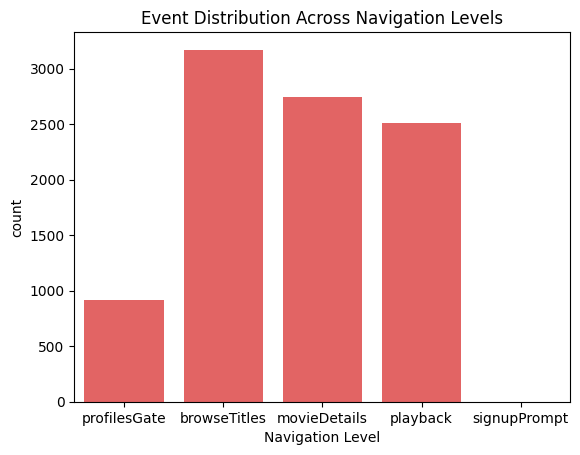

In [ ]:
# Show top navigation events (clickstream)
if 'Navigation Level' in clicks.columns:
    print(clicks['Navigation Level'].value_counts())

import seaborn as sns
step_order = ['profilesGate','browseTitles','movieDetails','playback','signupPrompt']
clicks['Navigation Level'] = pd.Categorical(clicks['Navigation Level'], categories=step_order, ordered=True)
sns.countplot(data=clicks, x='Navigation Level', order=step_order,color='#f74f4f')
plt.title('Event Distribution Across Navigation Levels')
plt.show()


In [ ]:
# Count unique users per funnel step
for step in step_order:
    n_users = clicks.loc[clicks['Navigation Level']==step, 'Profile Name'].nunique()
    print(f"{step}: {n_users} unique users")


profilesGate: 8 unique users
browseTitles: 9 unique users
movieDetails: 7 unique users
playback: 7 unique users
signupPrompt: 2 unique users


Primary Lang
en-IN    9
Name: count, dtype: int64


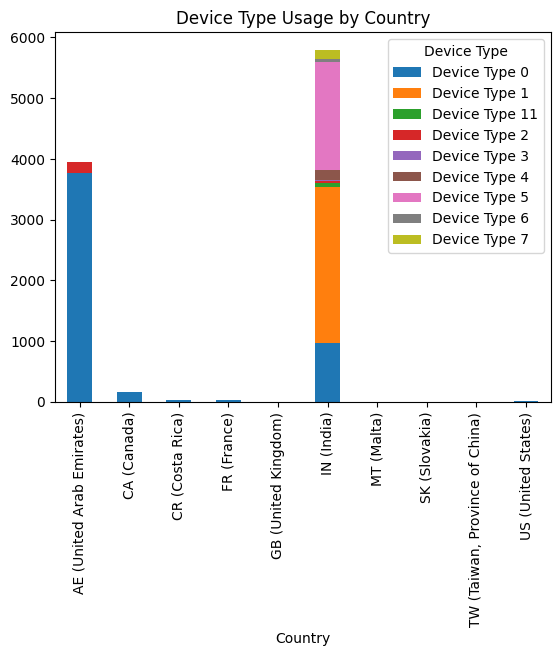

In [ ]:
# If you have demographic data in a profile table
if 'Primary Lang' in profiles_cleaned_again.columns:
    print(profiles_cleaned_again['Primary Lang'].value_counts())


# Cross-tab example (if Age/Country exists)
if 'Country' in view.columns:
    pd.crosstab(view['Country'], view['Device Type']).plot(kind='bar', stacked=True)
    plt.title('Device Type Usage by Country')
    plt.show()

Can You Do Funnel/Journey Analytics? (Event Steps)

In [ ]:
# Any columns with dates/times?
for dfname, df in tables.items():
    date_cols = [col for col in df.columns if any(x in col.lower() for x in ['time', 'date', 'start', 'end'])]
    for col in date_cols:
        print(f"\n{dfname} - {col}: Sample values")
        print(df[col].dropna().astype(str).head(3))



profiles - Profile Creation Time: Sample values
0    2021-10-29 05:42:00
1    2021-10-29 05:42:00
2    2021-10-29 05:42:00
Name: Profile Creation Time, dtype: object

devices - Acct First Playback Date: Sample values
0    2022-04-01T09:32:16.028Z
1    2021-12-24T14:40:29.147Z
2    2021-12-24T14:40:29.147Z
Name: Acct First Playback Date, dtype: object

devices - Acct Last Playback Date: Sample values
0    2022-11-07T12:57:43.624Z
1    2022-10-06T17:29:04.497Z
2    2022-10-06T17:29:04.497Z
Name: Acct Last Playback Date, dtype: object

devices - Acct First Playback Date For User Generated Plays: Sample values
0    2022-04-01T09:32:16.028Z
1    2021-12-24T14:40:29.147Z
2    2021-12-24T14:40:29.147Z
Name: Acct First Playback Date For User Generated Plays, dtype: object

devices - Acct Last Playback Date For User Generated Plays: Sample values
0    2022-11-07T12:57:43.624Z
1    2022-10-06T17:29:04.497Z
2    2022-10-06T17:29:04.497Z
Name: Acct Last Playback Date For User Generated Plays, dty

In [ ]:

for dfname, df in tables.items():
    for col in df.columns:
        if any(x in col.lower() for x in ['age', 'gender', 'lang', 'country']):
            print(f"{dfname}: {col} → {df[col].dropna().unique()[:10]}")


profiles: Primary Lang → ['en-IN']
clicks: Webpage Url → ['/youraccountlite?nftoken=BQAbAAEBEIMsZWkdOUoArZpcutUvxweAoKOLbS2pU0RXDRFhE5T9LceNs8IrD23V%2B9njDZebxuVCk9%2FdHZ8XPGEP604E5DEXQyOh9omBZ9jLvjeaZcpTVvHqism40%2BhBUT%2Bleps8Am1BLM0BVY8qY4dzaf%2FwQiFu9hGTQjUM18tTsDwQV2EyySAsqRfH0RYOwQzKuZrPaAuXZBAlUXZsAU5G%2FRSpWFAYeIN7RbkHdB5cxayXNFbKgOo%3D&inapp=true'
 '/youraccountlite?nftoken=BQAbAAEBEDjDCSG13aQFqDuXYZyfj9KAoFpGymtWNFFR4kUfm92hbTLRDVwzglNcMx4Q7m1rnnEG8ADNQmolPgnchiRFszrVMA3g74MnfV%2FUqT%2BmT%2F9JnZGbgBarQxPTm0yJwHhsWILYW%2FEWL5KpJMYtd1iKjGXdYyDNY61DqaABCdFsCoVKYOOmGDBiQ7s1g6rtoDpGYn1mYHDCbSD2p%2FTqDc5qQf6%2FLZIvPBuW1l9qypUZArXR7Jc%3D&inapp=true'
 '/youraccountlite?nftoken=BQAbAAEBEO0ZEvvm8maUkbuAbSJlaWOAoHNKOLNfCufsQbFZ%2FTKQVlAKWsD7gV%2Bd1gVm9IzULJQw%2Bp68t2gIEzzfLyd8QYj3o7ku409GFSvKLHzRqGLYZFU54snfIUzAmhyB%2Bph4%2FOhqyL6Og32%2Fi%2BZo10YZ5wYiheOFzI2SOjVHMf3EMa%2BTdxoPjvElkNqcetsLzCVIduQb8BmwdJHqhoN%2Bojb%2FfeVpXZFBnrwj%2FOitvciI5w6KErg%3D&inapp=true'
 '/browse']
search: Country

# **Funnel analytics**

**Define Funnel Steps**

What percent of users who visit profilesGate ever reach playback (i.e., go from app entry to streaming content).

In [ ]:
funnel_steps = [
    'profilesGate',
    'browseTitles',
    'movieDetails',
    'playback'
]


In [ ]:
def playback_conversion(df, group_name):
    users_at_profilesGate = set(df[df['Navigation Level'] == 'profilesGate']['Profile Name'])
    users_at_playback = set(df[df['Navigation Level'] == 'playback']['Profile Name'])
    converted = users_at_profilesGate & users_at_playback
    rate = len(converted) / len(users_at_profilesGate) if users_at_profilesGate else 0
    print(f"Percent of 'profilesGate' users who reach 'playback' ({group_name}): {rate:.2%} ({len(converted)}/{len(users_at_profilesGate)})")
    return users_at_profilesGate

playback_conversion(group_a, 'Source 0 (A)')
playback_conversion(group_b, 'Source 1 (B)')


Percent of 'profilesGate' users who reach 'playback' (Source 0 (A)): 87.50% (7/8)
Percent of 'profilesGate' users who reach 'playback' (Source 1 (B)): 100.00% (5/5)


{'User 4', 'User 5', 'User 6', 'User 7', 'User 8'}

For each pair of funnel steps, prints the percent of users who continue, and the drop-off rate so you see where the biggest user loss happens.

In [ ]:
import pandas as pd

# (Assume clicks_df is already loaded, and group_a, group_b are filtered DataFrames)
funnel_steps = [
    'profilesGate',
    'browseTitles',
    'movieDetails',
    'playback'
]

def funnel_stats(df, group_name):
    # Users who visited each step
    users_per_step = []
    for step in funnel_steps:
        users_per_step.append(set(df[df['Navigation Level'] == step]['Profile Name']))
    # Playback conversion from profilesGate
    converted = users_per_step[0] & users_per_step[-1]
    rate = len(converted) / len(users_per_step[0]) if users_per_step[0] else 0
    print(f"\n{group_name}: {len(converted)}/{len(users_per_step[0])} ({rate:.2%}) users from 'profilesGate' reached 'playback'.")
    # Stepwise drop-off
    prev_users = users_per_step[0]
    for i in range(1, len(funnel_steps)):
        overlap = prev_users & users_per_step[i]
        step_rate = len(overlap) / len(prev_users) if prev_users else 0
        dropoff = 1 - step_rate
        print(f"{funnel_steps[i-1]} → {funnel_steps[i]}: {len(overlap)}/{len(prev_users)} ({step_rate:.2%}) continued, drop-off: {dropoff:.2%}")
        prev_users = overlap

print("A/B Funnel Analysis")
funnel_stats(group_a, "Source 0 (A)")
funnel_stats(group_b, "Source 1 (B)")


A/B Funnel Analysis

Source 0 (A): 7/8 (87.50%) users from 'profilesGate' reached 'playback'.
profilesGate → browseTitles: 8/8 (100.00%) continued, drop-off: 0.00%
browseTitles → movieDetails: 7/8 (87.50%) continued, drop-off: 12.50%
movieDetails → playback: 7/7 (100.00%) continued, drop-off: 0.00%

Source 1 (B): 5/5 (100.00%) users from 'profilesGate' reached 'playback'.
profilesGate → browseTitles: 5/5 (100.00%) continued, drop-off: 0.00%
browseTitles → movieDetails: 5/5 (100.00%) continued, drop-off: 0.00%
movieDetails → playback: 5/5 (100.00%) continued, drop-off: 0.00%


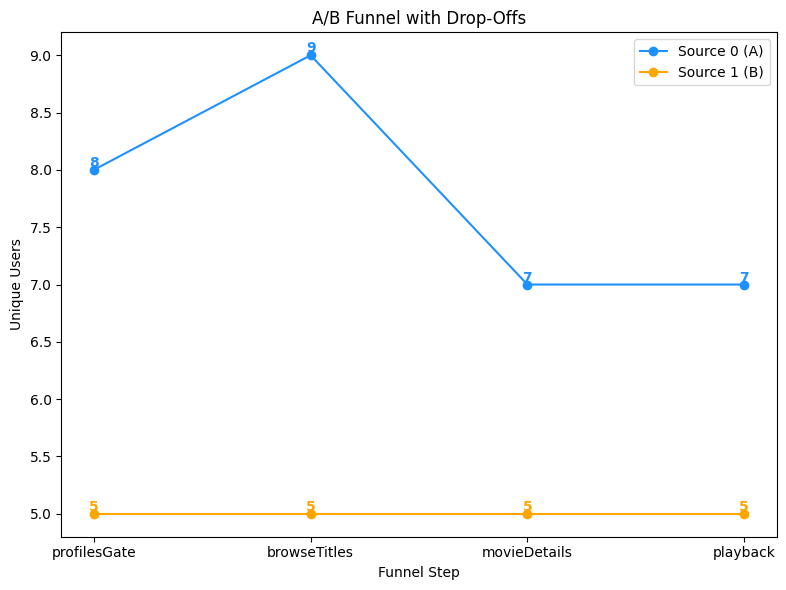

In [ ]:
import matplotlib.pyplot as plt

def funnel_plot(df, group_name, color):
    # Number of unique users at each funnel step
    counts = [df[df['Navigation Level'] == step]['Profile Name'].nunique() for step in funnel_steps]
    plt.plot(funnel_steps, counts, marker='o', label=group_name, color=color)
    for i, val in enumerate(counts):
        plt.text(i, val, str(val), color=color, ha='center', va='bottom', fontweight='bold')

plt.figure(figsize=(8,6))
funnel_plot(group_a, 'Source 0 (A)', 'dodgerblue')
funnel_plot(group_b, 'Source 1 (B)', 'orange')
plt.ylabel('Unique Users')
plt.xlabel('Funnel Step')
plt.title('A/B Funnel with Drop-Offs')
plt.legend()
plt.tight_layout()
plt.show()


**Engagement: The t-test showed no statistically significant difference in average engagement between users from "Source 0" and "Source 1". This means both sources are equally good at bringing in users who interact with the platform, so there's no reason to favor one over the other based on this metric alone.**

We built an engagement funnel using navigation levels to represent key steps in the user journey. For each Source group, we measured the number of unique users at each stage. The resulting funnel plot and drop-off calculations highlight at which step users from each group are most likely to disengage, enabling targeted optimization of the onboarding or content discovery flow.”

# **Onboarding Funnel**
*profilesGate → signupPrompt
Who enters and then starts signup?***

              A  B
profilesGate  8  5
browseTitles  9  5
movieDetails  7  5
playback      7  5
signupPrompt  2  0


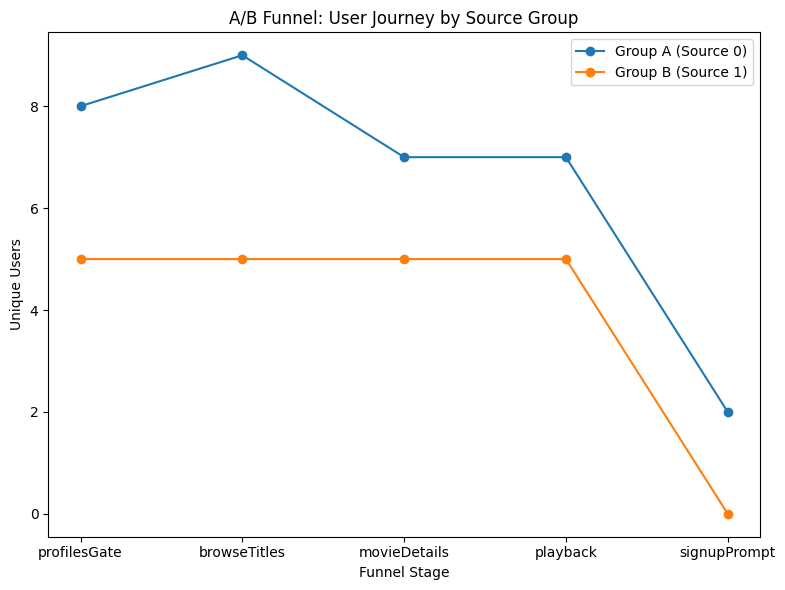

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt

# Load your data
clicks_df = pd.read_csv('/content/drive/MyDrive/PLAN OF ACTION/PROJECTS/datasets_churn/All_Clickstream.csv')

# Ensure timestamp is datetime
clicks_df['Click Utc Ts'] = pd.to_datetime(clicks_df['Click Utc Ts'])

# Define your A and B groups
group_labels = {'Source 0': 'A', 'Source 1': 'B'}
clicks_df['Group'] = clicks_df['Source'].map(group_labels)

# Define the funnel steps in order
funnel_steps = [
    'profilesGate',
    'browseTitles',
    'movieDetails',
    'playback',
    'signupPrompt'
]

# Function to count unique users at each step for each group
def funnel_counts(df, steps, group):
    counts = []
    for step in steps:
        n_users = df[df['Navigation Level'] == step]['Profile Name'].nunique()
        counts.append(n_users)
    return counts

funnel_data = {}
for source in ['Source 0', 'Source 1']:
    group_df = clicks_df[clicks_df['Source'] == source]
    funnel_data[group_labels[source]] = funnel_counts(group_df, funnel_steps, group_labels[source])

# To DataFrame for plotting
funnel_df = pd.DataFrame(funnel_data, index=funnel_steps)
print(funnel_df)

# Plot the funnel
plt.figure(figsize=(8,6))
plt.plot(funnel_df.index, funnel_df['A'], marker='o', label='Group A (Source 0)')
plt.plot(funnel_df.index, funnel_df['B'], marker='o', label='Group B (Source 1)')
plt.ylabel('Unique Users')
plt.xlabel('Funnel Stage')
plt.title('A/B Funnel: User Journey by Source Group')
plt.legend()
plt.tight_layout()
plt.show()


In [ ]:
for label in ['A', 'B']:
    print(f"\n--- Funnel for Group {label} ---")
    prev = None
    for i, (stage, n) in enumerate(zip(funnel_steps, funnel_df[label])):
        if i == 0:
            print(f"{stage}: {n} users")
            prev = n
        else:
            if prev > 0:
                dropoff = 1 - n/prev
            else:
                dropoff = 0
            print(f"{stage}: {n} users  (drop-off from prev: {dropoff:.1%})")
            prev = n



--- Funnel for Group A ---
profilesGate: 8 users
browseTitles: 9 users  (drop-off from prev: -12.5%)
movieDetails: 7 users  (drop-off from prev: 22.2%)
playback: 7 users  (drop-off from prev: 0.0%)
signupPrompt: 2 users  (drop-off from prev: 71.4%)

--- Funnel for Group B ---
profilesGate: 5 users
browseTitles: 5 users  (drop-off from prev: 0.0%)
movieDetails: 5 users  (drop-off from prev: 0.0%)
playback: 5 users  (drop-off from prev: 0.0%)
signupPrompt: 0 users  (drop-off from prev: 100.0%)


By quantifying user progression and drop-off at each stage for different acquisition groups, I provided actionable insight on where and why users disengage—informing targeted UX and marketing interventions.”

In [ ]:
# Merge Device Type into clickstream
click_with_device = clicks_cleaned_again.merge(
    devices_cleaned_again[['Profile Name', 'Device Type']], on='Profile Name', how='left'
)

In [ ]:
funnel_steps = [
    'profilesGate',
    'browseTitles',
    'movieDetails',
    'playback',
    'signupPrompt',  # add/remove as needed
]


In [ ]:
def funnel_by_group(clicks, group_col, funnel_steps):
    results = []
    for group_val in clicks[group_col].dropna().unique():
        group_df = clicks[clicks[group_col] == group_val]
        # Users who entered funnel
        funnel_users = set(group_df[group_df['Navigation Level'] == funnel_steps[0]]['Profile Name'])
        prev_users = funnel_users
        step_counts = [len(funnel_users)]
        drop_offs = []
        for step in funnel_steps[1:]:
            step_users = set(group_df[group_df['Navigation Level'] == step]['Profile Name']) & prev_users
            drop_offs.append(100 * (len(prev_users) - len(step_users)) / (len(prev_users) if prev_users else 1))
            prev_users = step_users
            step_counts.append(len(step_users))
        results.append({
            'Group': group_val,
            'Step_Users': step_counts,
            'DropOffs': drop_offs
        })
    return results


#**Funnel by Device Type**

In [ ]:
device_funnel_results = funnel_by_group(click_with_device, 'Device Type', funnel_steps)

# Display nicely
for res in device_funnel_results:
    print(f"\nDevice: {res['Group']}")
    for i, users in enumerate(res['Step_Users']):
        print(f"  {funnel_steps[i]}: {users} users")
    print("  Drop-Offs (stepwise, %):", ["{:.1f}%".format(d) for d in res['DropOffs']])



Device: Device Type 5
  profilesGate: 6 users
  browseTitles: 6 users
  movieDetails: 5 users
  playback: 5 users
  signupPrompt: 2 users
  Drop-Offs (stepwise, %): ['0.0%', '16.7%', '0.0%', '60.0%']

Device: Device Type 1
  profilesGate: 8 users
  browseTitles: 8 users
  movieDetails: 7 users
  playback: 7 users
  signupPrompt: 2 users
  Drop-Offs (stepwise, %): ['0.0%', '12.5%', '0.0%', '71.4%']

Device: Device Type 4
  profilesGate: 6 users
  browseTitles: 6 users
  movieDetails: 5 users
  playback: 5 users
  signupPrompt: 2 users
  Drop-Offs (stepwise, %): ['0.0%', '16.7%', '0.0%', '60.0%']

Device: Device Type 2
  profilesGate: 6 users
  browseTitles: 6 users
  movieDetails: 5 users
  playback: 5 users
  signupPrompt: 2 users
  Drop-Offs (stepwise, %): ['0.0%', '16.7%', '0.0%', '60.0%']

Device: Device Type 0
  profilesGate: 8 users
  browseTitles: 8 users
  movieDetails: 7 users
  playback: 7 users
  signupPrompt: 2 users
  Drop-Offs (stepwise, %): ['0.0%', '12.5%', '0.0%', '71.

In [ ]:
print(sorted(devices_cleaned_again['Device Type'].unique()))

['Device Type 0', 'Device Type 1', 'Device Type 10', 'Device Type 11', 'Device Type 2', 'Device Type 3', 'Device Type 4', 'Device Type 5', 'Device Type 6', 'Device Type 7', 'Device Type 8', 'Device Type 9']


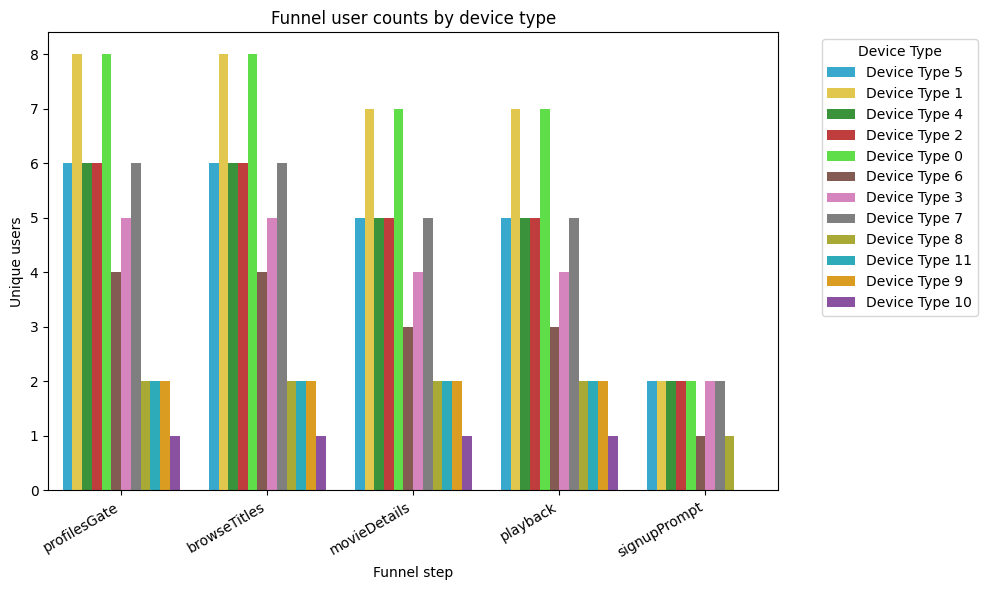

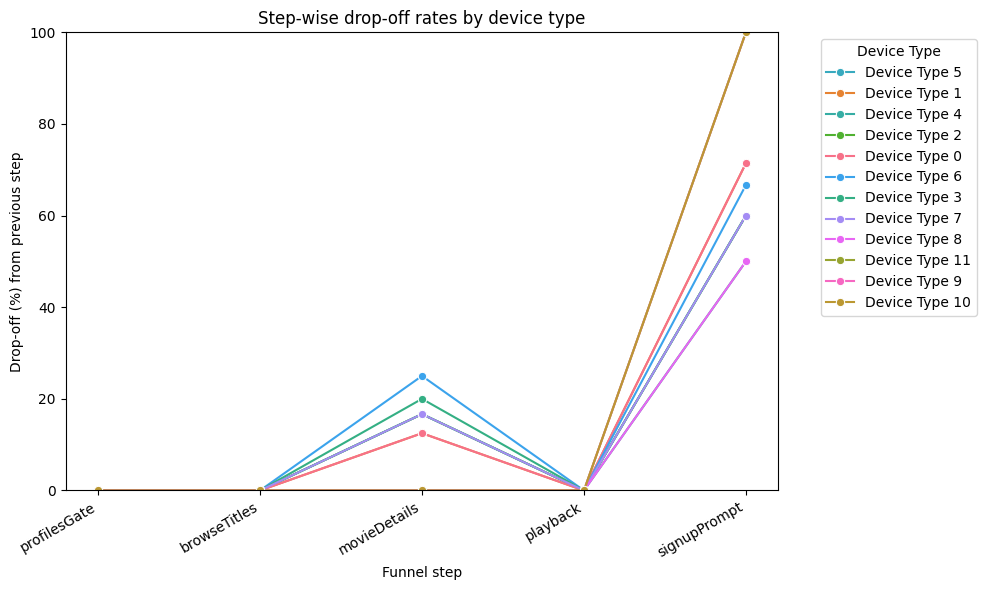

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from itertools import cycle

# ─────────────────────────────────────────────────────────────
# 1.  Re-shape device_funnel_results  →  long DataFrames
# ─────────────────────────────────────────────────────────────
rows_cnt, rows_drop = [], []
for res in device_funnel_results:
    dev = res["Group"]                           # device label
    for step, users in zip(funnel_steps, res["Step_Users"]):
        rows_cnt.append({"device": dev, "step": step, "users": users})

    # prepend 0 % drop for the first step so lengths match funnel_steps
    for i, drop in enumerate([0] + res["DropOffs"]):
        rows_drop.append({"device": dev,
                          "step_idx": i,
                          "step": funnel_steps[i],
                          "drop": drop})         # may be NaN

df_cnt  = pd.DataFrame(rows_cnt)
df_drop = pd.DataFrame(rows_drop)

# ─────────────────────────────────────────────────────────────
# 2.  Custom list of distinct colours  (extend or edit at will)
# ─────────────────────────────────────────────────────────────
my_colors = [
    "#20b4e6",  # bright blue
    "#fad637",  # orange
    "#2ca02c",  # green
    "#d62728",  # red
    "#4ff731",  # purple
    "#8c564b",  # brown
    "#e377c2",  # pink
    "#7f7f7f",  # gray
    "#bcbd22",  # olive
    "#17becf",  # cyan
    "#f9a602",  # gold
    "#8e44ad",  # violet
]

palette = {dev: col for dev, col in zip(
    df_cnt["device"].unique(),
    cycle(my_colors)                 # cycle if > len(my_colors)
)}

# ─────────────────────────────────────────────────────────────
# 3.  Bar chart – user counts per funnel step
# ─────────────────────────────────────────────────────────────
plt.figure(figsize=(10, 6))
sns.barplot(data=df_cnt,
            x="step", y="users",
            hue="device", palette=palette)
plt.title("Funnel user counts by device type")
plt.xlabel("Funnel step")
plt.ylabel("Unique users")
plt.xticks(rotation=30, ha="right")
plt.legend(title="Device Type",
           bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()

# ─────────────────────────────────────────────────────────────
# 4.  Line chart – drop-off % (keep *all* devices)
#     → replace NaN with 0 so devices with no data show flat line
# ─────────────────────────────────────────────────────────────

import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np

# ─────────────────────────────────────────────────────────────
# 1.  Make a truly-distinct colour for *every* device
#    • Uses Seaborn “husl” space → evenly-spaced hues
# ─────────────────────────────────────────────────────────────
devices_unique = sorted(df_drop["device"].unique())        # sorted for legend order
N               = len(devices_unique)

# generate N visually-distinct colours (husl = H, S, L evenly spaced)
distinct_cols   = sns.color_palette("husl", N)
palette         = {dev: col for dev, col in zip(devices_unique, distinct_cols)}

# ─────────────────────────────────────────────────────────────
# 2.  Line chart – drop-off %   (all devices, no NaNs)
# ─────────────────────────────────────────────────────────────
plot_df          = df_drop.copy()
plot_df["drop"]  = plot_df["drop"].fillna(0)               # flat-at-0 if missing

plt.figure(figsize=(10, 6))
sns.lineplot(data=plot_df,
             x="step_idx", y="drop",
             hue="device", marker="o",
             palette=palette)

plt.xticks(range(len(funnel_steps)), funnel_steps,
           rotation=30, ha="right")
plt.ylabel("Drop-off (%) from previous step")
plt.xlabel("Funnel step")
plt.title("Step-wise drop-off rates by device type")
plt.ylim(0, 100)
plt.legend(title="Device Type",
           bbox_to_anchor=(1.05, 1), loc="upper left")
plt.tight_layout()
plt.show()


**Define A and B Groups by Source**

In [ ]:
# Count navigation events per user
engagement_a = group_a.groupby('Profile Name')['Navigation Level'].count()
engagement_b = group_b.groupby('Profile Name')['Navigation Level'].count()

print("Avg events per user (Group A):", engagement_a.mean())
print("Avg events per user (Group B):", engagement_b.mean())


Avg events per user (Group A): 1008.5555555555555
Avg events per user (Group B): 604.4


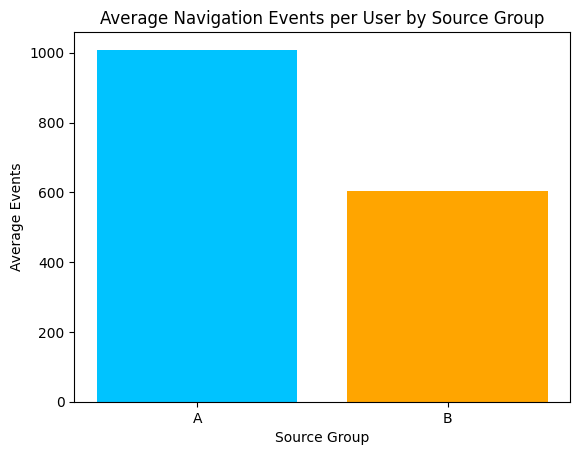

In [ ]:
import matplotlib.pyplot as plt

data = {
    'A': engagement_a.mean(),
    'B': engagement_b.mean()
}
plt.bar(data.keys(), data.values(), color=['#00c3ff', 'orange'])
plt.title('Average Navigation Events per User by Source Group')
plt.ylabel('Average Events')
plt.xlabel('Source Group')
plt.show()


**Retention Rate per Source**

*Here we define retention as the percentage of users who have activity on more than one day.*

In [ ]:
# Convert timestamp to datetime
clicks_cleaned_again['Click Utc Ts'] = pd.to_datetime(clicks_cleaned_again['Click Utc Ts'])

def retention_rate(df, source_label):
    # Users who have clicks on more than one date
    df = df.copy()
    df['Click Utc Ts'] = pd.to_datetime(df['Click Utc Ts']) # Add conversion here
    df['Date'] = df['Click Utc Ts'].dt.date
    user_dates = df.groupby('Profile Name')['Date'].nunique()
    retained = (user_dates > 1).sum()
    total = user_dates.count()
    rate = retained / total if total > 0 else 0
    print(f"Retention Rate ({source_label}): {rate:.2%} ({retained}/{total} users)")

retention_rate(group_a, 'Source 0 (A)')
retention_rate(group_b, 'Source 1 (B)')

Retention Rate (Source 0 (A)): 77.78% (7/9 users)
Retention Rate (Source 1 (B)): 80.00% (4/5 users)


# **A/B cohort**
Conversion Rate Analysis

In [ ]:
import pandas as pd

# Suppose your main DataFrame is `session_df` (e.g., merged search + view logs)
# For this example, use your merged session_with_search table
session_df = session_with_search.copy()

# Assign cohort: Odd Profile Name -> 'A', Even -> 'B'
def assign_cohort(profile_name):
    try:
        # Extract user number from 'User N'
        num = int(profile_name.split()[-1])
        return 'A' if num % 2 == 1 else 'B'
    except:
        return 'B'  # fallback if can't parse

session_df['Cohort'] = session_df['Profile Name'].apply(assign_cohort)



In [ ]:
# If your data has 'Action', 'Start Time', and 'Search_Utc_Ts', you can do this:

# Conversion: any search-action that leads to a play within 30 seconds
session_df['Search_to_Play'] = (
    (session_df['Action'] == 'select') &
    ((session_df['Start Time'] - session_df['Start Time'].min()).dt.total_seconds() <= 30)
)
# Or for demonstration, use whatever column or logic indicates a successful play.


In [ ]:
# Conversion rate: number of conversions / total number of eligible events per cohort
conversion_stats = (
    session_df.groupby('Cohort')['Search_to_Play']
    .agg(['sum', 'count'])
    .rename(columns={'sum': 'Conversions', 'count': 'Total'})
)
conversion_stats['Conversion Rate'] = conversion_stats['Conversions'] / conversion_stats['Total']
print(conversion_stats)


        Conversions  Total  Conversion Rate
Cohort                                     
A                 3   1912         0.001569
B                 0   8080         0.000000


In [ ]:
import pandas as pd

# Assume search_cleaned_again and view_cleaned_again are your search and viewing DataFrames
search_df = search_cleaned_again.copy()
view_df = view_cleaned_again.copy()

# Merge on Profile Name and Title (Displayed Name from search, Title from view)
merged = pd.merge(
    search_df, view_df,
    left_on=['Profile Name', 'Displayed Name'],
    right_on=['Profile Name', 'Title'],
    suffixes=('_search', '_view'),
    how='inner'
)

# Now, for each row in merged, conversion happened (search was followed by play for same title)
merged['Conversion'] = 1

# For cohort assignment (as before)
def assign_cohort(profile_name):
    try:
        num = int(profile_name.split()[-1])
        return 'A' if num % 2 == 1 else 'B'
    except:
        return 'B'
merged['Cohort'] = merged['Profile Name'].apply(assign_cohort)

# Conversion rate per cohort
cohort_stats = merged.groupby('Cohort')['Conversion'].agg(['sum', 'count'])
cohort_stats['Conversion Rate'] = cohort_stats['sum'] / cohort_stats['count']
print(cohort_stats)


         sum  count  Conversion Rate
Cohort                              
A       1231   1231              1.0
B       2635   2635              1.0


In [ ]:
# Suppose clicks has 'Navigation Level' column and 'details' means user viewed details page
clicks_df = clicks.copy()
details_plays = pd.merge(
    clicks_df[clicks_df['Navigation Level'] == 'movieDetails'], # Corrected column name and value
    view_df,
    left_on=['Profile Name', 'Webpage Url'],  # or another relevant field
    right_on=['Profile Name', 'Title'],
    how='inner'
)
details_plays['Conversion'] = 1
# Same cohort assignment and aggregation as above

# **User Tenure (“New” vs. “Experienced”) A/B Funnel**

In [ ]:
# Define tenure groups based on Profile Creation Time
user_master['Profile Creation Time'] = pd.to_datetime(user_master['Profile Creation Time'])
cutoff_date = user_master['Profile Creation Time'].median() # Or another suitable cutoff

user_master['Tenure_Group'] = user_master['Profile Creation Time'].apply(
    lambda x: 'New' if x <= cutoff_date else 'Experienced'
)

click_with_tenure = clicks_cleaned_again.merge(
    user_master[['Profile Name', 'Tenure_Group']], on='Profile Name', how='left'
)
tenure_funnel_results = funnel_by_group(click_with_tenure, 'Tenure_Group', funnel_steps)

# Display nicely
for res in tenure_funnel_results:
    print(f"\nTenure Group: {res['Group']}")
    for i, users in enumerate(res['Step_Users']):
        print(f"  {funnel_steps[i]}: {users} users")
    print("  Drop-Offs (stepwise, %):", ["{:.1f}%".format(d) for d in res['DropOffs']])


Tenure Group: New
  profilesGate: 4 users
  browseTitles: 4 users
  movieDetails: 3 users
  playback: 3 users
  signupPrompt: 2 users
  Drop-Offs (stepwise, %): ['0.0%', '25.0%', '0.0%', '33.3%']

Tenure Group: Experienced
  profilesGate: 4 users
  browseTitles: 4 users
  movieDetails: 4 users
  playback: 4 users
  signupPrompt: 0 users
  Drop-Offs (stepwise, %): ['0.0%', '0.0%', '0.0%', '100.0%']


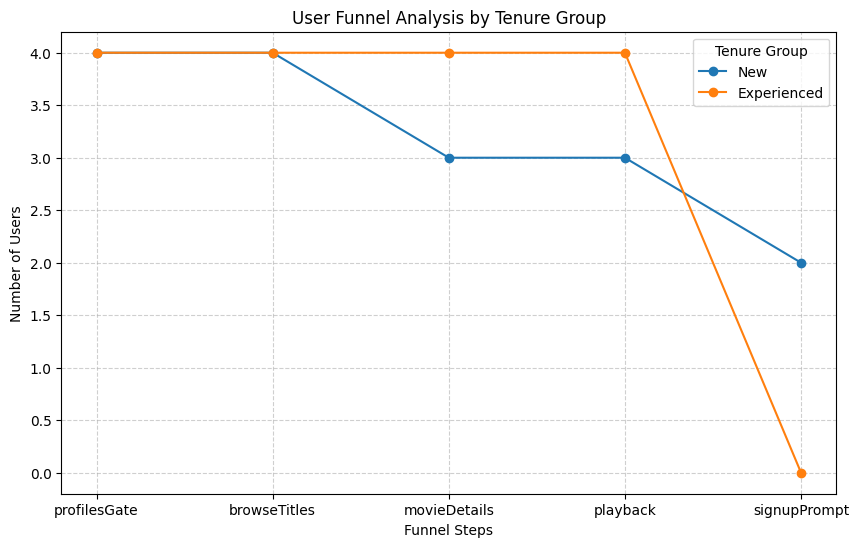

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# The 'tenure_funnel_results' variable and 'funnel_steps' list from your code snippet
# will be used here. Assuming they are structured as shown in your prompt.
# For example:
# tenure_funnel_results = [
#     {'Group': 'New', 'Step_Users': [1000, 800, 500, 300], 'DropOffs': [20.0, 37.5, 40.0]},
#     {'Group': 'Experienced', 'Step_Users': [2500, 2000, 1500, 1000], 'DropOffs': [20.0, 25.0, 33.3]}
# ]
# funnel_steps = ['Step 1', 'Step 2', 'Step 3', 'Step 4']

# Create a DataFrame for easier plotting
data_for_plot = []
for result in tenure_funnel_results:
    for i, users in enumerate(result['Step_Users']):
        data_for_plot.append({
            'Tenure_Group': result['Group'],
            'Funnel_Step': funnel_steps[i],
            'Users': users
        })
plot_df = pd.DataFrame(data_for_plot)

# Plot the data
plt.figure(figsize=(10, 6))
for group in plot_df['Tenure_Group'].unique():
    group_data = plot_df[plot_df['Tenure_Group'] == group]
    plt.plot(group_data['Funnel_Step'], group_data['Users'], marker='o', label=group)

plt.title('User Funnel Analysis by Tenure Group')
plt.xlabel('Funnel Steps')
plt.ylabel('Number of Users')
plt.legend(title='Tenure Group')
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

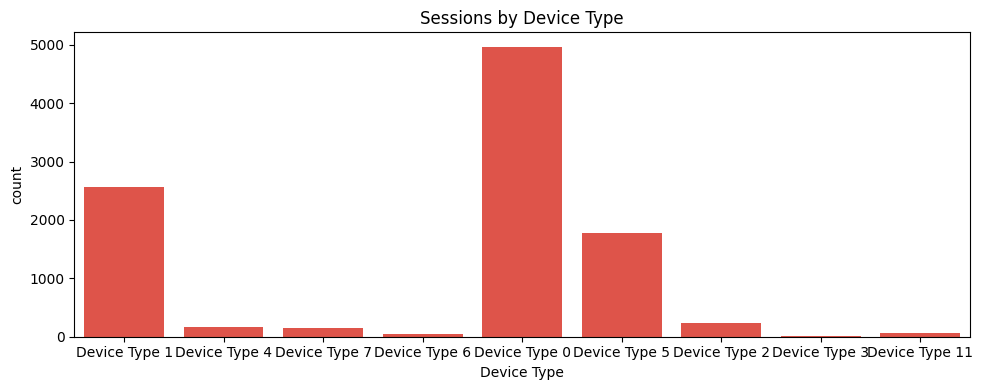

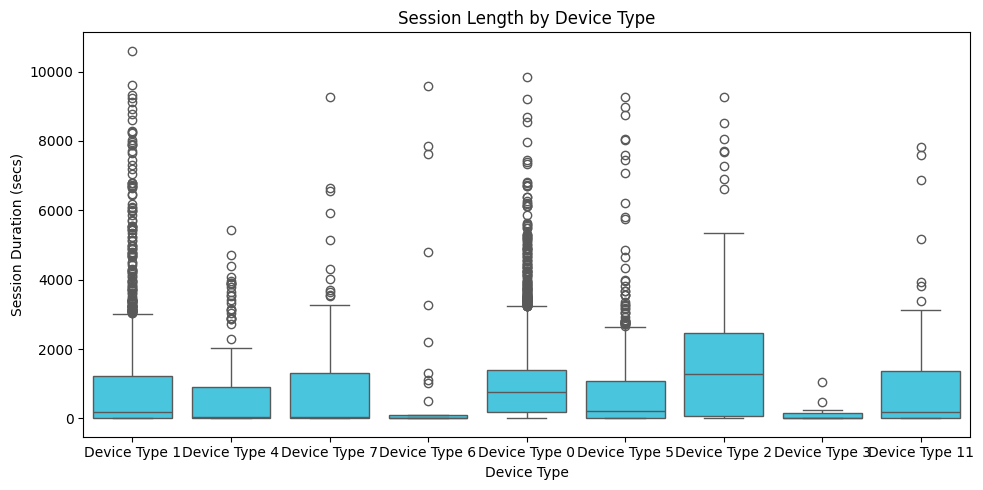

In [ ]:
import seaborn as sns

# Distribution of sessions per device
plt.figure(figsize=(10,4))
sns.countplot(x='Device Type', data=view,color="#f73f31")
plt.title('Sessions by Device Type')
plt.tight_layout()
plt.show()

# Engagement by device: boxplot
plt.figure(figsize=(10,5))
view['Duration_secs'] = pd.to_timedelta(view['Duration']).dt.total_seconds()
sns.boxplot(x='Device Type', y='Duration_secs', data=view, color="#31d6f7")
plt.title('Session Length by Device Type')
plt.ylabel('Session Duration (secs)')
plt.tight_layout()
plt.show()


# **Search Behavior — Country & Queries**

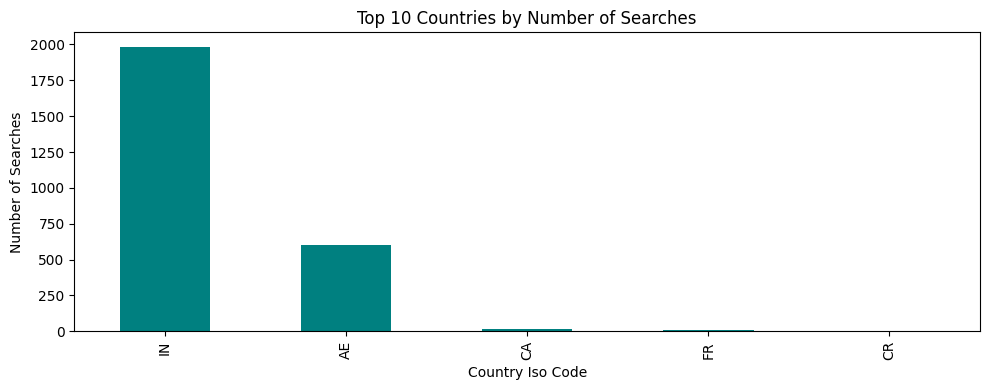

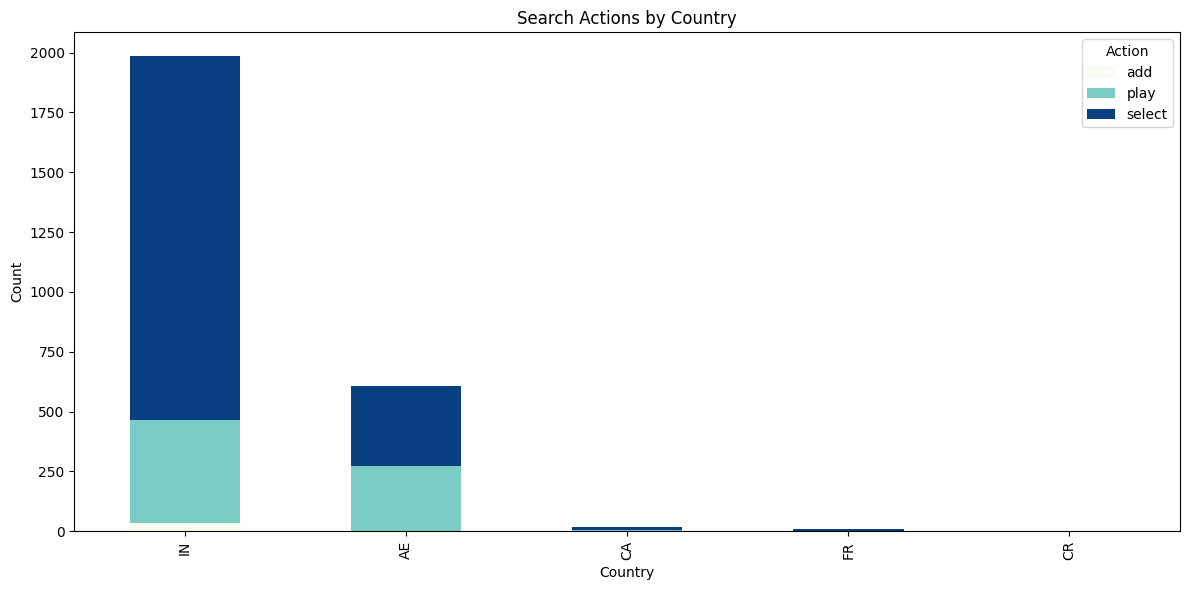

In [ ]:
# Count of searches by country
country_counts = search['Country Iso Code'].value_counts().head(10)
plt.figure(figsize=(10,4))
country_counts.plot(kind='bar', color='teal')
plt.title('Top 10 Countries by Number of Searches')
plt.ylabel('Number of Searches')
plt.tight_layout()
plt.show()

# Or: Actions by country (stacked)
pivot = pd.crosstab(search['Country Iso Code'], search['Action'])
pivot = pivot.loc[pivot.sum(axis=1).sort_values(ascending=False).head(8).index]
pivot.plot(kind='bar', stacked=True, figsize=(12,6), colormap='GnBu')
plt.title('Search Actions by Country')
plt.ylabel('Count')
plt.xlabel('Country')
plt.tight_layout()
plt.show()


What do people search for? (“Query Typed” EDA)

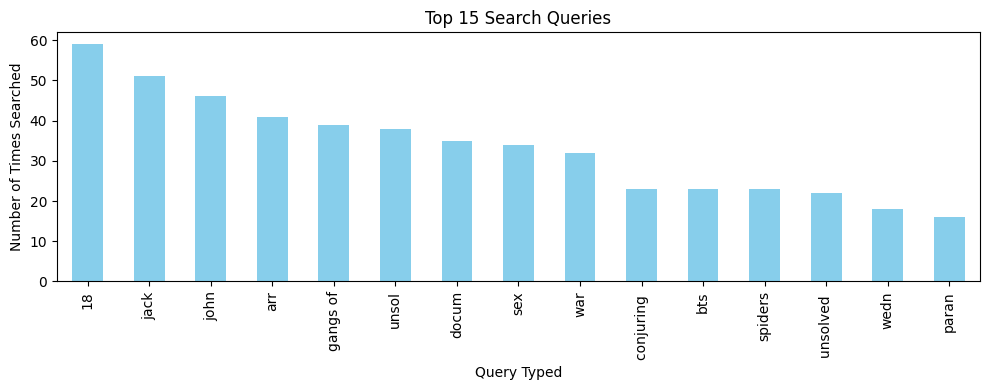

In [ ]:
# Most common search queries
search_terms = search['Query Typed'].value_counts().head(15)
plt.figure(figsize=(10,4))
search_terms.plot(kind='bar', color='skyblue')
plt.title('Top 15 Search Queries')
plt.ylabel('Number of Times Searched')
plt.tight_layout()
plt.show()


Combined: Which queries are popular in which countries?

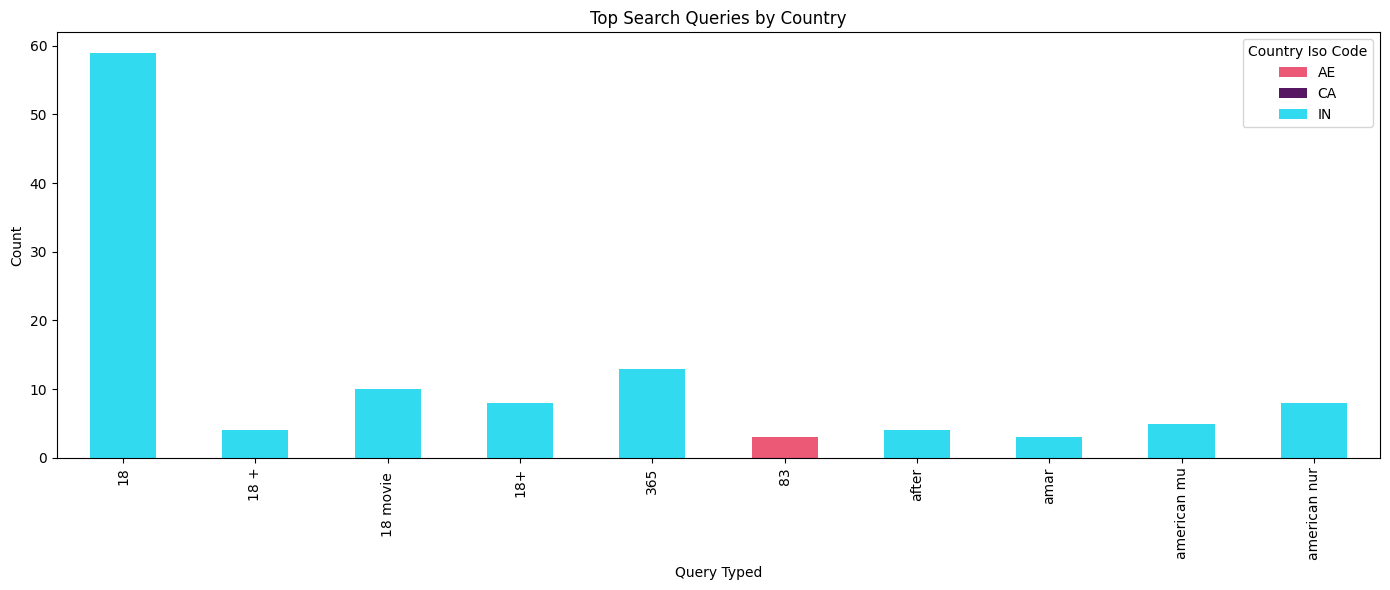

In [ ]:
pivot2 = pd.crosstab(
    search['Query Typed'],
    search['Country Iso Code']
).loc[lambda x: x.sum(axis=1)>2].head(10)  # Only show queries with >2 total, adjust as needed

pivot2.plot(kind='bar', stacked=True, figsize=(14,6), color=["#eb5976","#561661","#32daf0"])
plt.title('Top Search Queries by Country')
plt.xlabel('Query Typed')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


#**Search → Playback Conversion Logic**

Unique search queries per user:
 Profile Name
User 8    172
User 7     89
User 4     57
User 6     37
User 5     21
Name: Query Typed, dtype: int64


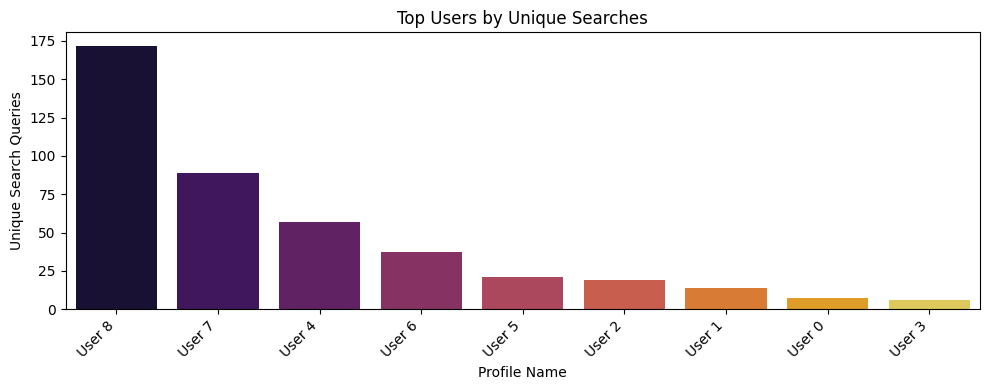

In [ ]:
# Search to play conversion: count users who search, then play within X mins
search = search_cleaned_again.copy()
search['Utc Timestamp'] = pd.to_datetime(search['Utc Timestamp'])

# Count unique search queries per user
searches_per_user = search.groupby('Profile Name')['Query Typed'].nunique().sort_values(ascending=False)
print("Unique search queries per user:\n", searches_per_user.head())

# (Optional) Visualize with barplot
plt.figure(figsize=(10,4))
sns.barplot(x=searches_per_user.head(15).index, y=searches_per_user.head(15).values, palette='inferno', hue=searches_per_user.head(15).index, legend=False)
plt.title('Top Users by Unique Searches')
plt.ylabel('Unique Search Queries')
plt.xlabel('Profile Name')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

In [ ]:
# Show unique titles searched by each user
searches_per_user_titles = search.groupby('Profile Name')['Displayed Name'].unique()

# Print or display as DataFrame (Top N users)
searches_per_user_titles = searches_per_user_titles.apply(lambda x: list(x))
searches_per_user_titles = searches_per_user_titles.reset_index().rename(columns={'Displayed Name': 'Unique Titles Searched'})

# Display Top N users
display(searches_per_user_titles.head(10))


,Profile Name,Unique Titles Searched
0,User 0,"[Vikings: Season 1: ""Burial of the Dead"", nan,..."
1,User 1,"[Chernobyl 1986, Gunjan Saxena: The Kargil Gir..."
2,User 2,"[nan, Stranger Things 3: The Game (Mobile Game..."
3,User 3,"[nan, Irul, Hey Sinamika, Hey Sinamika (Hindi)..."
4,User 4,"[Manifest: Season 1: ""Pilot"", nan, The Gray Ma..."
5,User 5,"[Minnal Murali, Extraction 2, nan, Pad Man, Mi..."
6,User 6,"[nan, The Elephant Whisperers, Gatta Kusthi, G..."
7,User 7,"[Against The Ice, The Platform, Land, Awake, A..."
8,User 8,"[Mrs. Chatterjee vs Norway, Brooklyn Nine-Nine..."


**Action Breakdown (Search Journey Steps)**

Visualize which actions are most common (add, select, play, etc).

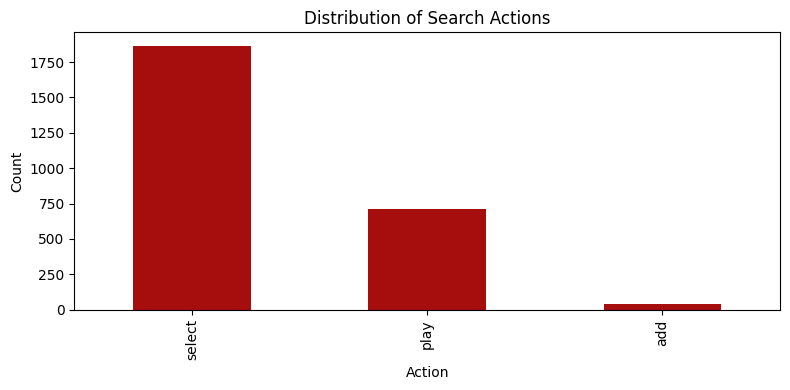

In [ ]:
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4))
search['Action'].value_counts().plot(kind='bar', color='#a60d0d')
plt.title('Distribution of Search Actions')
plt.xlabel('Action')
plt.ylabel('Count')
plt.tight_layout()
plt.show()


**Conversion Funnel: What % of searches lead to action (add/select/play)?**

In [ ]:
conversion = search['Action'].value_counts(normalize=True) * 100
print("Conversion funnel (percent of search actions):")
print(conversion)


Conversion funnel (percent of search actions):
Action
select    71.368502
play      27.217125
add        1.414373
Name: proportion, dtype: float64


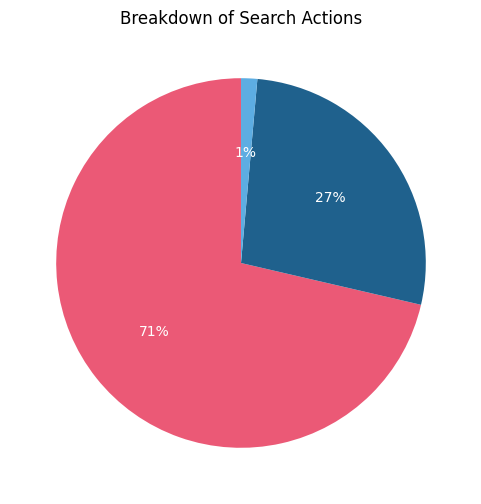

In [ ]:
search['Action'].value_counts().plot(kind='pie', autopct='%1.0f%%', startangle=90, figsize=(6,6), colors=['#eb5976', '#1F618D', '#5DADE2', '#AED6F1'],  textprops={'color': 'white'})
plt.ylabel('')
plt.title('Breakdown of Search Actions')
plt.show()

# **Monthly Watch-Time Aggregation**

In [ ]:
import pandas as pd

view = pd.read_csv('/content/drive/MyDrive/PLAN OF ACTION/PROJECTS/datasets_churn/All_ViewingActivity.csv')
view['Start Time'] = pd.to_datetime(view['Start Time'])
view['Duration'] = pd.to_timedelta(view['Duration'])

view['Month'] = view['Start Time'].dt.to_period('M').dt.to_timestamp()
monthly_watch = view.groupby('Month')['Duration'].sum().dt.total_seconds().reset_index()
monthly_watch.columns = ['ds', 'y']
print(monthly_watch)

           ds          y
0  2021-10-01     6970.0
1  2021-11-01   155678.0
2  2021-12-01   399821.0
3  2022-01-01   573809.0
4  2022-02-01   902885.0
5  2022-03-01   814229.0
6  2022-04-01   910043.0
7  2022-05-01   462450.0
8  2022-06-01  1025967.0
9  2022-07-01   410982.0
10 2022-08-01   608530.0
11 2022-09-01   115937.0
12 2022-10-01   261194.0
13 2022-11-01   240648.0
14 2022-12-01   177218.0
15 2023-01-01   497158.0
16 2023-02-01   333440.0
17 2023-03-01   211733.0
18 2023-04-01   355164.0
19 2023-05-01   291853.0
20 2023-06-01   178136.0


In [ ]:
import pandas as pd

# Ensure columns are named for Prophet
prophet_df = monthly_watch.copy()
prophet_df.columns = ['ds', 'y']
prophet_df['ds'] = pd.to_datetime(prophet_df['ds'])


In [ ]:
from prophet import Prophet

# Instantiate and fit model
m = Prophet()
m.fit(prophet_df)

# Create future months for forecasting (e.g., 6 future months)
future = m.make_future_dataframe(periods=6, freq='M')

# Make prediction
forecast = m.predict(future)


INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwmnu2dsy/9q5gb9c1.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwmnu2dsy/5690q_4r.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=48142', 'data', 'file=/tmp/tmpwmnu2dsy/9q5gb9c1.json', 'init=/tmp/tmpwmnu2dsy/5690q_4r.json', 'output', 'file=/tmp/tmpwmnu2dsy/prophet_model5dc6udd8/prophet_model-20251001150359.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:03:59 - cmdstanpy - INFO - Chain [1] start processing
I

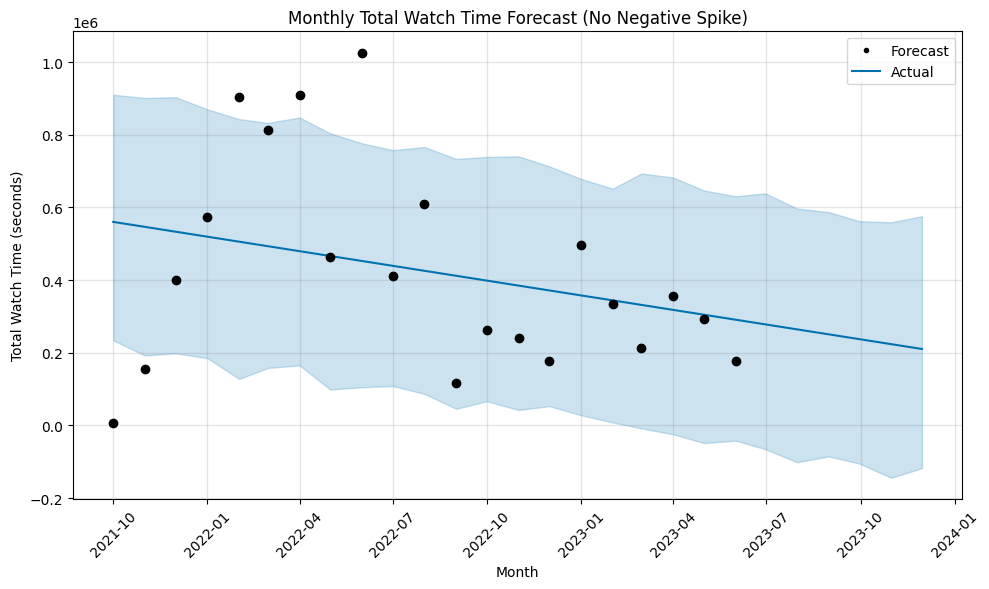

In [ ]:
import matplotlib.pyplot as plt

# Prophet's built-in plot
fig = m.plot(forecast)
plt.title('Monthly Total Watch Time Forecast (No Negative Spike)')
plt.ylabel('Total Watch Time (seconds)')
plt.xlabel('Month')
plt.xticks(rotation=45)

# Overlay your actuals as dots for clarity
plt.scatter(prophet_df['ds'], prophet_df['y'], color='black', label='Actual', zorder=5)
plt.legend(['Forecast', 'Actual'])
plt.tight_layout()
plt.show()


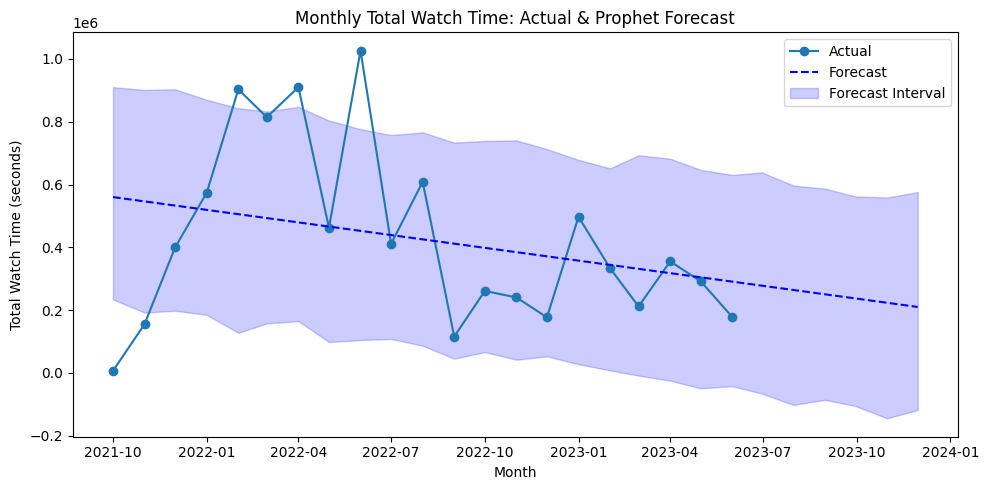

In [ ]:
plt.figure(figsize=(10,5))
# Plot actuals
plt.plot(prophet_df['ds'], prophet_df['y'], marker='o', label='Actual')
# Plot forecast (Prophet's yhat)
plt.plot(forecast['ds'], forecast['yhat'], '--', color='blue', label='Forecast')
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'], color='blue', alpha=0.2, label='Forecast Interval')
plt.title('Monthly Total Watch Time: Actual & Prophet Forecast')
plt.ylabel('Total Watch Time (seconds)')
plt.xlabel('Month')
plt.legend()
plt.tight_layout()
plt.show()


"The plot below shows both historical monthly watch time (solid line with dots, up to mid-2023) and the Prophet model’s forecast (dashed line and shaded confidence interval) for the next two years. The forecast begins at the vertical dashed line. While actual data is only available until mid-2023, the model predicts future watch time through 2025, showing a declining trend with increasing uncertainty."

# **Prophet Forecast (Watch Time)**

INFO:prophet:Disabling yearly seasonality. Run prophet with yearly_seasonality=True to override this.
INFO:prophet:Disabling weekly seasonality. Run prophet with weekly_seasonality=True to override this.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
INFO:prophet:n_changepoints greater than number of observations. Using 15.
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwmnu2dsy/tlh7zecb.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmpwmnu2dsy/naq8vzxe.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.12/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=7361', 'data', 'file=/tmp/tmpwmnu2dsy/tlh7zecb.json', 'init=/tmp/tmpwmnu2dsy/naq8vzxe.json', 'output', 'file=/tmp/tmpwmnu2dsy/prophet_modelaj5_3oj4/prophet_model-20251001150400.csv', 'method=optimize', 'algorithm=newton', 'iter=10000']
15:04:00 - cmdstanpy - INFO - Chain [1] start processing
IN

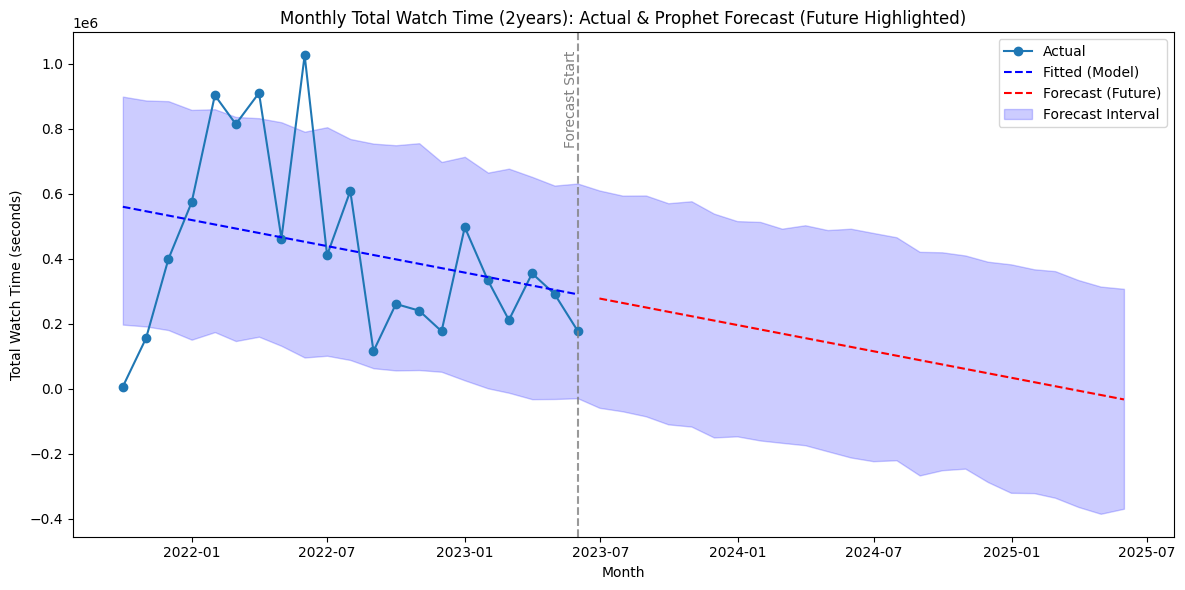

In [ ]:
import matplotlib.pyplot as plt
import pandas as pd
from prophet import Prophet

# Prepare your data (replace with your table if needed)
monthly_watch = pd.read_csv('/content/drive/MyDrive/PLAN OF ACTION/PROJECTS/datasets_churn/All_ViewingActivity.csv')
monthly_watch['Start Time'] = pd.to_datetime(monthly_watch['Start Time'])
monthly_watch['Duration'] = pd.to_timedelta(monthly_watch['Duration'])
monthly_watch['Month'] = monthly_watch['Start Time'].dt.to_period('M').dt.to_timestamp()
df = monthly_watch.groupby('Month')['Duration'].sum().dt.total_seconds().reset_index()
df.columns = ['ds', 'y']
df['ds'] = pd.to_datetime(df['ds'])

# Fit Prophet
m = Prophet()
m.fit(df)

# Forecast for next 24 months
future = m.make_future_dataframe(periods=24, freq='M')
forecast = m.predict(future)


# Last actual date
last_actual = df['ds'].max()

# Separate forecast into actual vs. future periods
forecast_actual = forecast[forecast['ds'] <= last_actual]
forecast_future = forecast[forecast['ds'] > last_actual]

plt.figure(figsize=(12,6))
# Actuals
plt.plot(df['ds'], df['y'], marker='o', label='Actual', color='tab:blue')

# Forecast (historical period): dashed blue
plt.plot(forecast_actual['ds'], forecast_actual['yhat'], '--', color='blue', label='Fitted (Model)')

# Forecast (future): dashed orange
plt.plot(forecast_future['ds'], forecast_future['yhat'], '--', color='red', label='Forecast (Future)')

# Forecast Interval
plt.fill_between(forecast['ds'], forecast['yhat_lower'], forecast['yhat_upper'],
                 color='blue', alpha=0.2, label='Forecast Interval')

# Vertical line to mark forecast start
plt.axvline(last_actual, color='gray', linestyle='--', alpha=0.8)
plt.text(last_actual, plt.ylim()[1]*0.95, 'Forecast Start', rotation=90, va='top', ha='right', color='gray')

plt.title('Monthly Total Watch Time (2years): Actual & Prophet Forecast (Future Highlighted)')
plt.ylabel('Total Watch Time (seconds)')
plt.xlabel('Month')
plt.legend()
plt.tight_layout()
plt.show()